In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 500
    model.Params.MIPGap = 0.1
    model.Params.Presolve = 2
    model.Params.MIPFocus = 1
    model.Params.Heuristics = 0.8
    model.Params.Threads = 8
    model.Params.Seed = 42

In [2]:
# Parameters 
# CPU, Tasks, E, L, Chain
m = 8
K = 5
L_levels = [25, 20, 15, 12, 10]
E_levels = [13, 28, 38, 45, 90] 
CPU_capacity = [3000] * m
f_v_levels = [30, 40, 60, 80, 100]
P_idle = [16] * m
P_max = [40] * m
T_total = 300
total_tasks = 150
from collections import Counter

# Task chain definitions
chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}


num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # Total number of tasks
buffer = 0.2  
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]


In [ ]:
#Gurobi Baseline and Optimal
def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp") 
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   

   

    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    print("\n📋 Chain Activation Overview:")
    for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")
   

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    print("\n🔍 Task Energy Level Overview:")
    for i in range(n):
        if task_energy_levels[i] != -1:
            print(f"Task {i} -> Level {task_energy_levels[i]} (Energy = {E_levels[task_energy_levels[i]]})")


    return {
    "model": "Gurobi-Baseline" if baseline else "Gurobi-Optimal",
    "E_PU_max": E_PU_max,
    "alphas": (alpha_1, alpha_2, alpha_3),
    "objective": model.ObjVal,
    "acceptance_rate": len(accepted_chains) / num_chains,  
    "total_pu_energy": sum(E_PU[j].X for j in range(m)),
    "total_task_energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
    "runtime": model.Runtime,
    

    "Accepted Chains": len(accepted_chains),
    "Total Chains": num_chains,
    "PU Task Assignment": pu_task_map,
    "Task Energy Levels": task_energy_levels,
    "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]
}


In [4]:
#Greedy

def run_greedy_model(alpha_1=2500, alpha_2=10, alpha_3=1, E_PU_max=None):
    import time
    start_time = time.time()

    if E_PU_max is None:
        E_PU_max = [8000] * m

    delta = [0] * n
    y = [-1] * n
    w = [-1] * n
    z = [0] * num_chains

    pu_remaining_cpu = CPU_capacity[:]
    pu_workload = [0] * m
    accepted_chains = 0

    task_energy_levels = [-1] * n
    pu_task_map = {j: [] for j in range(m)}

    print("\n===== [Greedy chain Information] =====")
    for k in range(num_chains):
        task_list = chain_tasks[k]
        task_energy_per_chain = []
        task_cpu_usage = []
        chain_latency = 0
        chain_cpu = 0
        feasible = True

        for i in task_list:
            level = None
            for l in reversed(range(K)):  
                level = l
                break  

            latency = L_levels[level]
            cpu = f_v_levels[level]
            task_energy_per_chain.append(level)
            task_cpu_usage.append(cpu)
            chain_latency += latency
            chain_cpu += cpu

        total_chain_latency = chain_latency + (len(task_list) - 1)
        if total_chain_latency > L_max[k]:
            print(f"❌ Chain {k} skipped: latency not（all Latency ≈ {total_chain_latency}, limits = {L_max[k]}）")
            continue

        assigned_to_pu = False
        for j in range(m):
            if pu_remaining_cpu[j] >= chain_cpu:
                new_workload = pu_workload[j] + sum(L_levels[task_energy_per_chain[idx]] for idx in range(len(task_list)))
                new_pu_energy = P_idle[j] * (T_total - new_workload) + (P_max[j] - P_idle[j]) * new_workload
                if new_pu_energy > E_PU_max[j]:
                    continue  

                for idx, i in enumerate(task_list):
                    delta[i] = 1
                    y[i] = task_energy_per_chain[idx]
                    w[i] = j
                    task_energy_levels[i] = task_energy_per_chain[idx]
                    pu_task_map[j].append(i)
                    pu_remaining_cpu[j] -= task_cpu_usage[idx]
                    pu_workload[j] += L_levels[task_energy_per_chain[idx]]
                z[k] = 1
                accepted_chains += 1
                assigned_to_pu = True
                print(f"✅ Chain {k} activated (PU {j}, total latency = {total_chain_latency}, total CPU = {chain_cpu})")
                break

        if not assigned_to_pu:
            print(f"❌ Chain {k} skipped: latency ok but all PUs exceed energy/resource limits (CPU = {chain_cpu})")

    # Total Energy
    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = [
        P_idle[j] * (T_total - pu_workload[j]) + (P_max[j] - P_idle[j]) * pu_workload[j]
        for j in range(m)
    ]
    total_pu_energy = sum(pu_energy)
    total_energy = maf_energy + total_pu_energy
    acceptance_rate = accepted_chains / num_chains
    runtime = time.time() - start_time
    objective = alpha_1 * sum(z) - alpha_2 * maf_energy - alpha_3 * total_pu_energy

    print(f"Greedy Summary: Accepted {accepted_chains}/{num_chains} chains, acceptance_rate = {acceptance_rate:.2%}")

    for j in range(m):
        print(f"PU {j}: Energy = {pu_energy[j]:.2f} / Limit = {E_PU_max[j]}")

    return {
        "objective": objective,
        "acceptance_rate": acceptance_rate,
        "total_energy": total_energy,
        "runtime": runtime,
        "details": {
            "accepted_chains": accepted_chains,
            "total_pu_energy": total_pu_energy,
            "total_task_energy": maf_energy,
            "activated_chain_list": z,
            "task_energy_levels": task_energy_levels,
            "pu_task_assignment": pu_task_map
        }
    }


In [5]:
# Greedy / Gurobi Optimal / Gurobi Baseline 
def run_all_models(E_PU_max_list, alpha_combinations):
    results = []

    for E_PU_max in E_PU_max_list:
        for alpha_1, alpha_2, alpha_3 in alpha_combinations:
            print(f"Test Data: alpha=({alpha_1}, {alpha_2}, {alpha_3}), E_PU_max={E_PU_max}")

            # Run Gurobi Baseline
            print("Gurobi [Baseline]")
            result_baseline = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                baseline=True,
                E_PU_max=E_PU_max
            )
            if result_baseline:
                result_baseline["model"] = "Gurobi-Baseline"
                result_baseline["E_PU_max"] = E_PU_max.copy()
                result_baseline["alphas"] = (alpha_1, alpha_2, alpha_3)
                results.append(result_baseline)

            # Run Gurobi Optimal
            print("Gurobi [Optimal]")
            result_optimal = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                baseline=False,
                E_PU_max=E_PU_max
            )
            if result_optimal:
                result_optimal["model"] = "Gurobi-Optimal"
                result_optimal["E_PU_max"] = E_PU_max.copy()
                result_optimal["alphas"] = (alpha_1, alpha_2, alpha_3)
                results.append(result_optimal)

            # Run Greedy
            print("Greedy")
            result_greedy = run_greedy_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                E_PU_max=E_PU_max
            )
            result_greedy["model"] = "Greedy"
            result_greedy["E_PU_max"] = E_PU_max.copy()
            result_greedy["alphas"] = (alpha_1, alpha_2, alpha_3)
            results.append(result_greedy)

    return results


def plot_all_model(all_results):   
    standardized = []
    for r in all_results:
        standardized.append({
            "model": r.get("model", r.get("Mode", "Unknown")),
            "E_PU_max": r["E_PU_max"] if isinstance(r["E_PU_max"], list) else [r["E_PU_max"]],
            "alphas": r.get("alphas", (None, None, None)),
            "objective": r.get("objective", r.get("Objective Value")),
            "acceptance_rate": r.get("acceptance_rate", r.get("Accepted Chains", 0) / r.get("Total Chains", 1)),
            "total_task_energy": r.get("total_task_energy", r.get("Total Task Energy")),
            "total_pu_energy": r.get("total_pu_energy", r.get("Total PU Energy")),
            "runtime": r.get("runtime", r.get("Runtime"))
        })

    df = pd.DataFrame(standardized)
    df["E_PU_max_label"] = df["E_PU_max"].apply(lambda x: x[0])

    
    metrics = {
        "acceptance_rate": "Accepted Chains (%)",
        "total_task_energy": "Total Task Energy",
        "total_pu_energy": "Total PU Energy",
        "objective": "Objective Value",
        "runtime": "Runtime (s)"
    }

    figs = []

    for metric_key, metric_label in metrics.items():
        fig, ax = plt.subplots(figsize=(8, 5))

        pivot = df.pivot(index="E_PU_max_label", columns="model", values=metric_key)
        if metric_key == "acceptance_rate":
            pivot *= 100  # %

        pivot.plot(kind="bar", ax=ax)
        ax.set_title(metric_label)
        ax.set_ylabel(metric_label)
        ax.set_xlabel("E_PU_max")
        ax.legend(title="Model")

        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

        plt.xticks(rotation=0)
        plt.tight_layout()
        figs.append(fig)

    return figs

In [6]:
def plot_model(all_results, save_folder=None):

    import os

    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    for i in range(0, len(all_results), 3):
        models = {r["model"]: r for r in all_results[i:i+3]}
        if "Gurobi-Baseline" in models and "Gurobi-Optimal" in models and "Greedy" in models:
            e_max_val = models["Greedy"]["E_PU_max"][0]
            alpha_val = models["Greedy"].get("alphas", ("?", "?", "?"))
            alpha_str = f"α=({alpha_val[0]}, {alpha_val[1]}, {alpha_val[2]})"

            
            fig, axs = plt.subplots(2, 2, figsize=(16, 10))
            labels = ["Gurobi Baseline", "Gurobi Optimal", "Greedy"]

           
            result_baseline = models["Gurobi-Baseline"]
            result_optimal = models["Gurobi-Optimal"]
            result_greedy = models["Greedy"]

            times = [result_baseline["runtime"], result_optimal["runtime"], result_greedy["runtime"]]
            acceptance = [result_baseline["acceptance_rate"], result_optimal["acceptance_rate"], result_greedy["acceptance_rate"]]
            energy_baseline = result_baseline["total_pu_energy"] + result_baseline["total_task_energy"]
            energy_optimal = result_optimal["total_pu_energy"] + result_optimal["total_task_energy"]
            energy_greedy = result_greedy["total_energy"]
            total_energy = [energy_baseline, energy_optimal, energy_greedy]
            saving_values = [0,
                             (energy_baseline - energy_optimal) / energy_baseline * 100,
                             (energy_baseline - energy_greedy) / energy_baseline * 100]

            # 替换颜色为更协调的组合（例如：蓝紫色系）
            new_colors = ["#6A5ACD", "#20B2AA", "#FFA07A"]  # 紫色、青色、浅橙色

            # 1. Execution Time
            axs[0, 0].bar(labels, times, color=new_colors)
            axs[0, 0].set_title("Execution Time (s)")
            for i, v in enumerate(times):
                axs[0, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

            # 2. Chain Acceptance
            axs[0, 1].bar(labels, acceptance, color=new_colors)
            axs[0, 1].set_title("Chain Acceptance Rate")
            axs[0, 1].set_ylim(0, 1)
            for i, v in enumerate(acceptance):
                axs[0, 1].text(i, v, f"{v:.1%}", ha='center', va='bottom')

            # 3. Total Energy Consumption
            axs[1, 0].bar(labels, total_energy, color=new_colors)
            axs[1, 0].set_title("Total Energy Consumption")
            for i, v in enumerate(total_energy):
                axs[1, 0].text(i, v, f"{v:.1f}", ha='center', va='bottom')

            # 4. Energy Savings Compared to Baseline
            axs[1, 1].bar(labels, saving_values, color=new_colors)
            axs[1, 1].set_title("Energy Savings Compared to Baseline (%)")
            axs[1, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
            for i, v in enumerate(saving_values):
                axs[1, 1].text(i, v, f"{v:.2f}%", ha='center', va='bottom')

            fig.suptitle(f"E_PU_max = {e_max_val} | {alpha_str}", fontsize=16)
            fig.tight_layout(rect=[0, 0, 1, 0.96])


            plt.show()


In [7]:
E_PU_max_list = [
    [4900] * m,
    [5000] * m,
    [5400] * m,
    [5700] * m,
    [6000] * m,
]

Test Data: alpha=(25000, 1.5, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16
⏱️ Gurobi Runtime: 0.12 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ❌ Not activated, Tasks: [58, 59, 60]
Chain 7: ❌ Not activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 

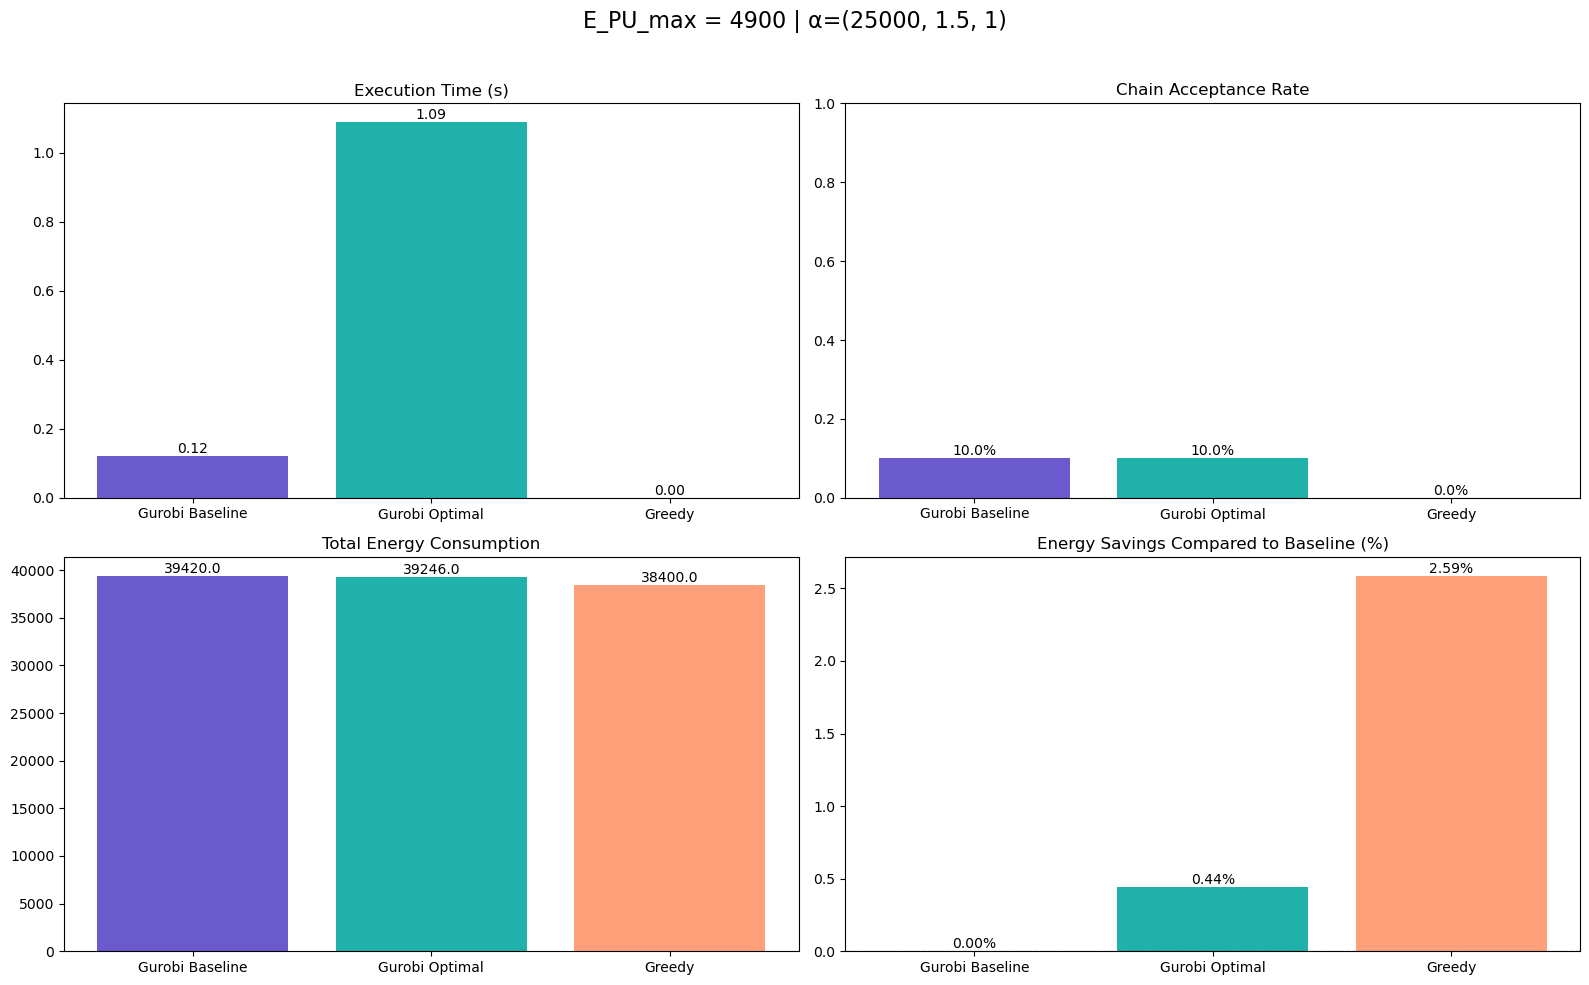

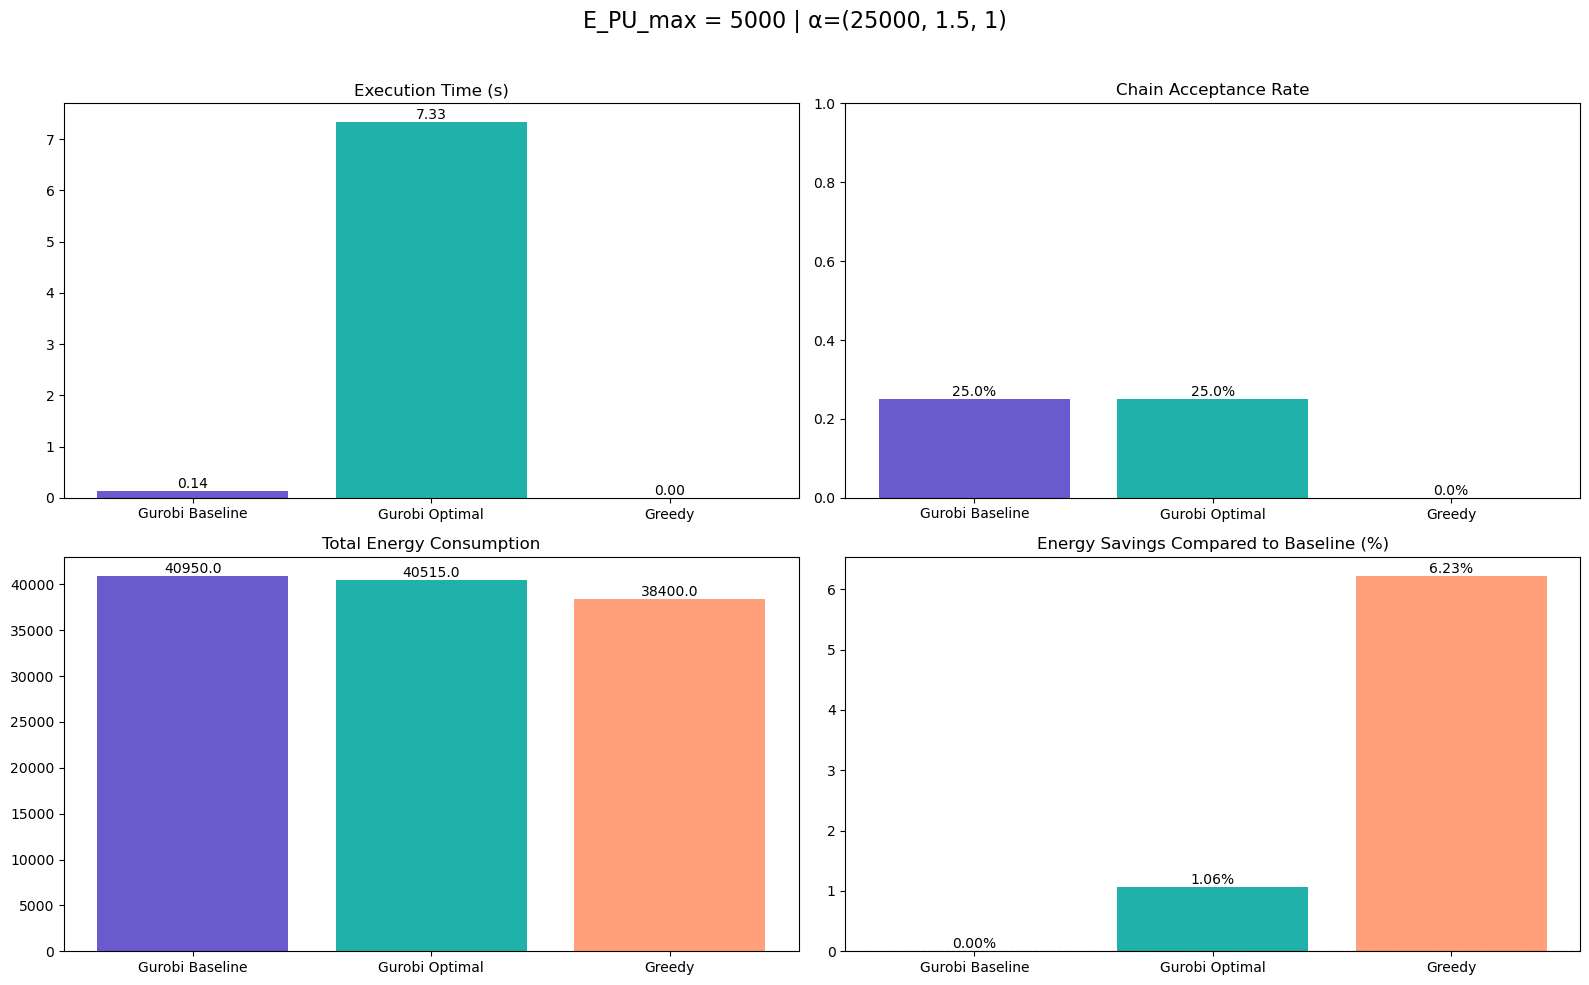

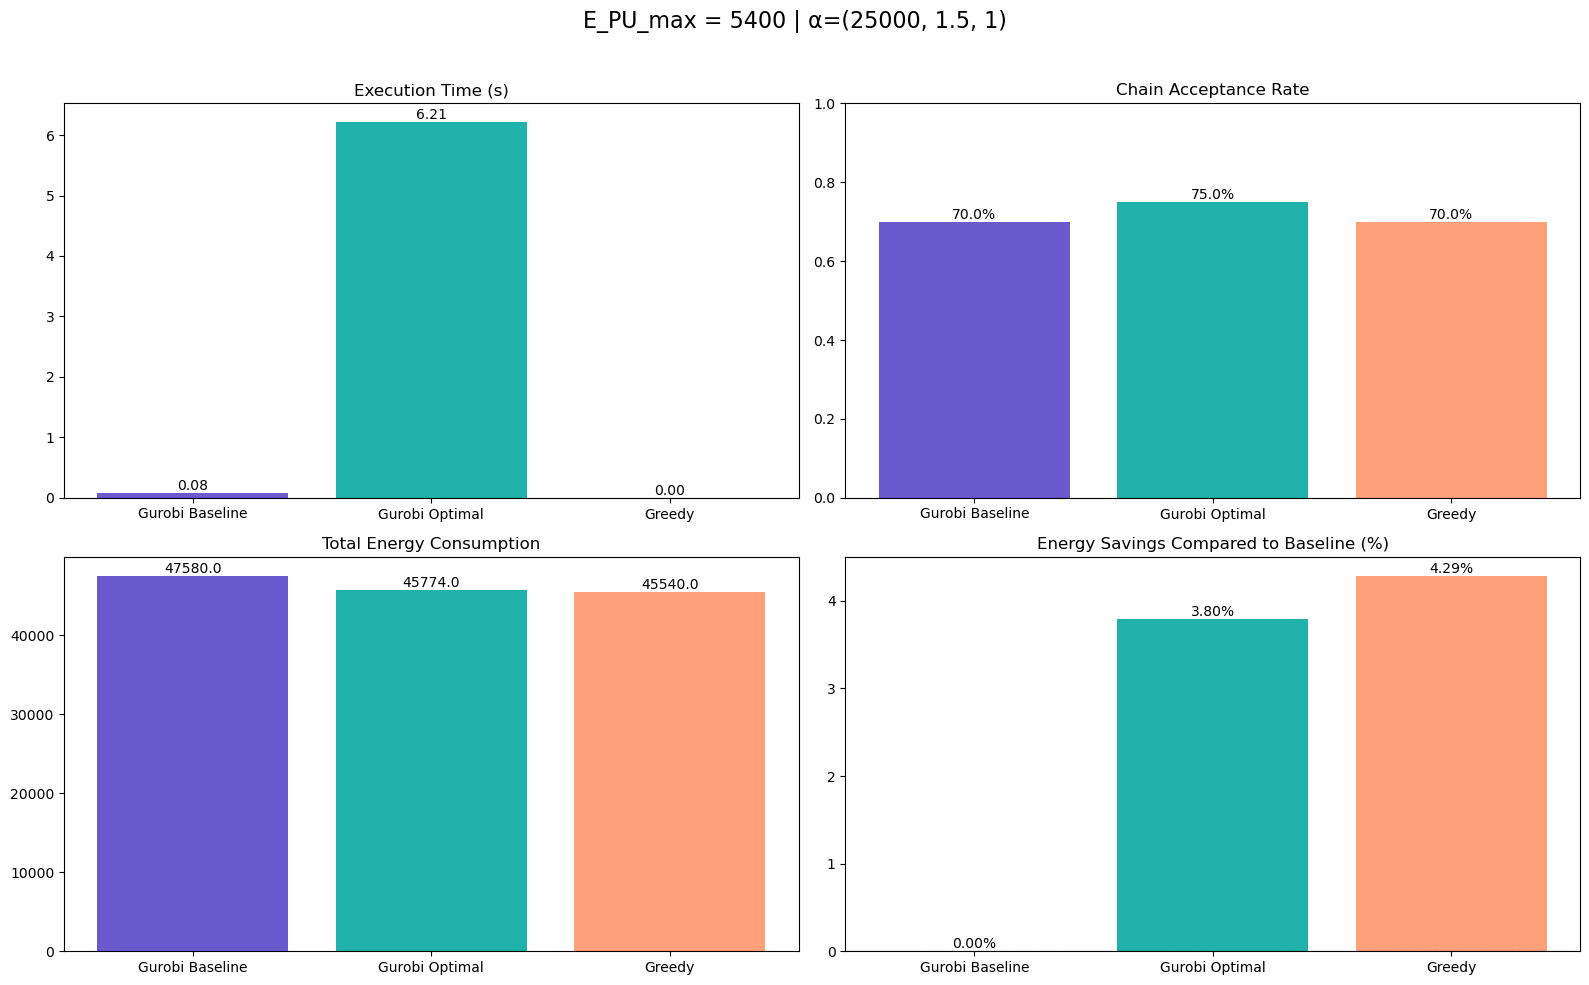

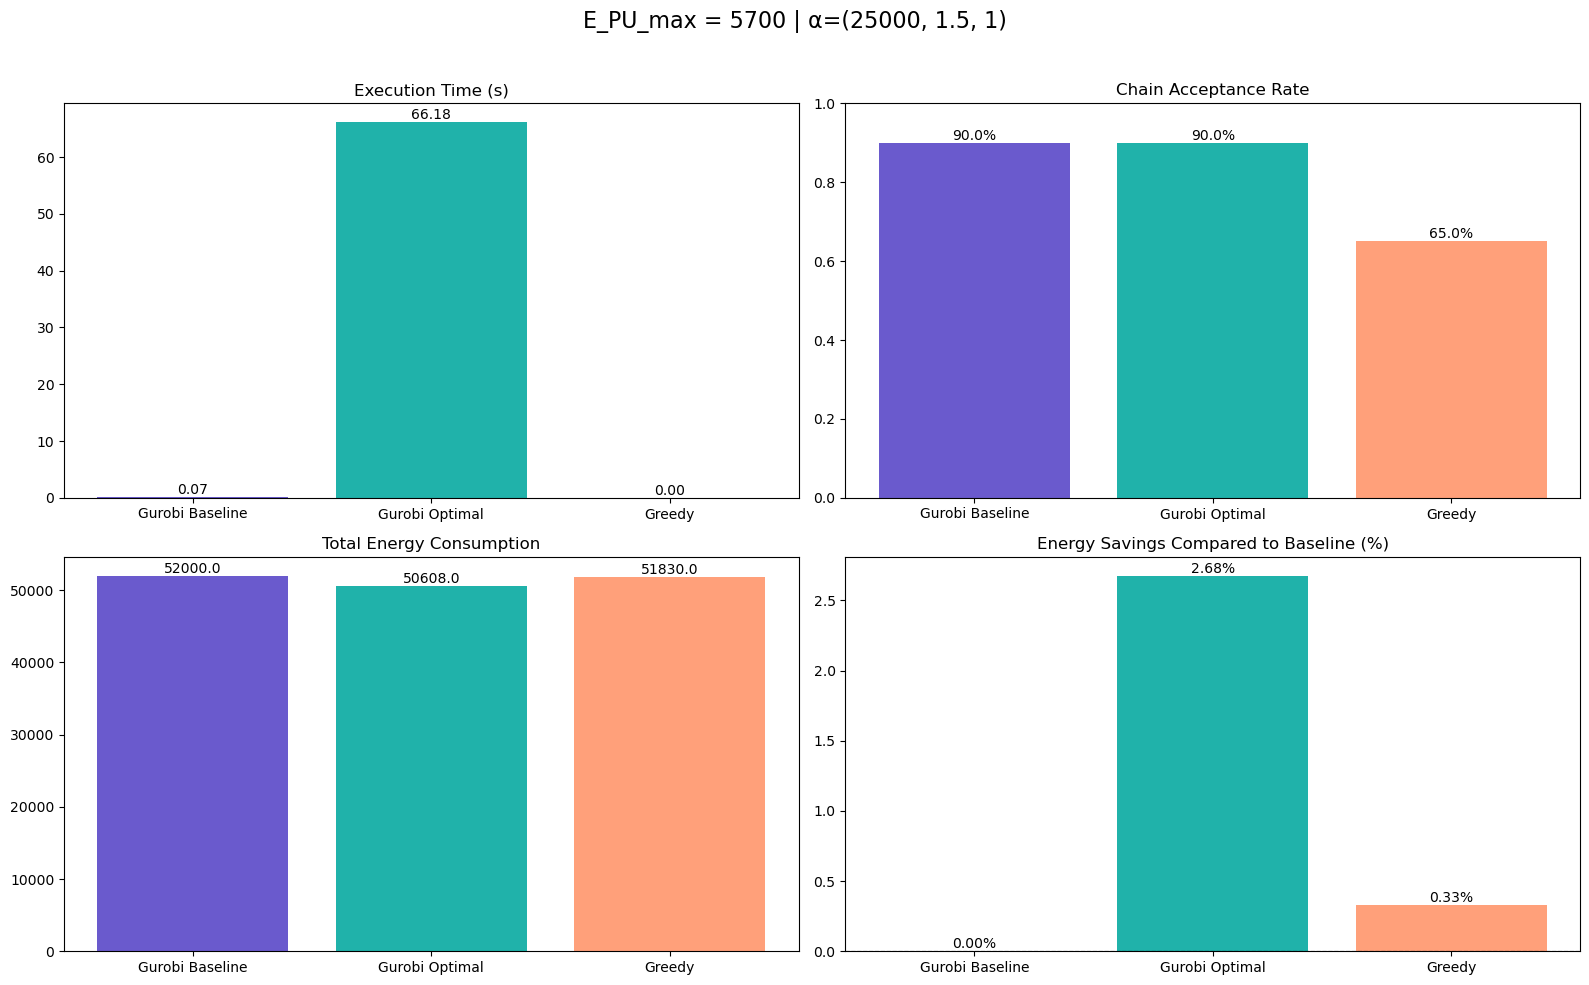

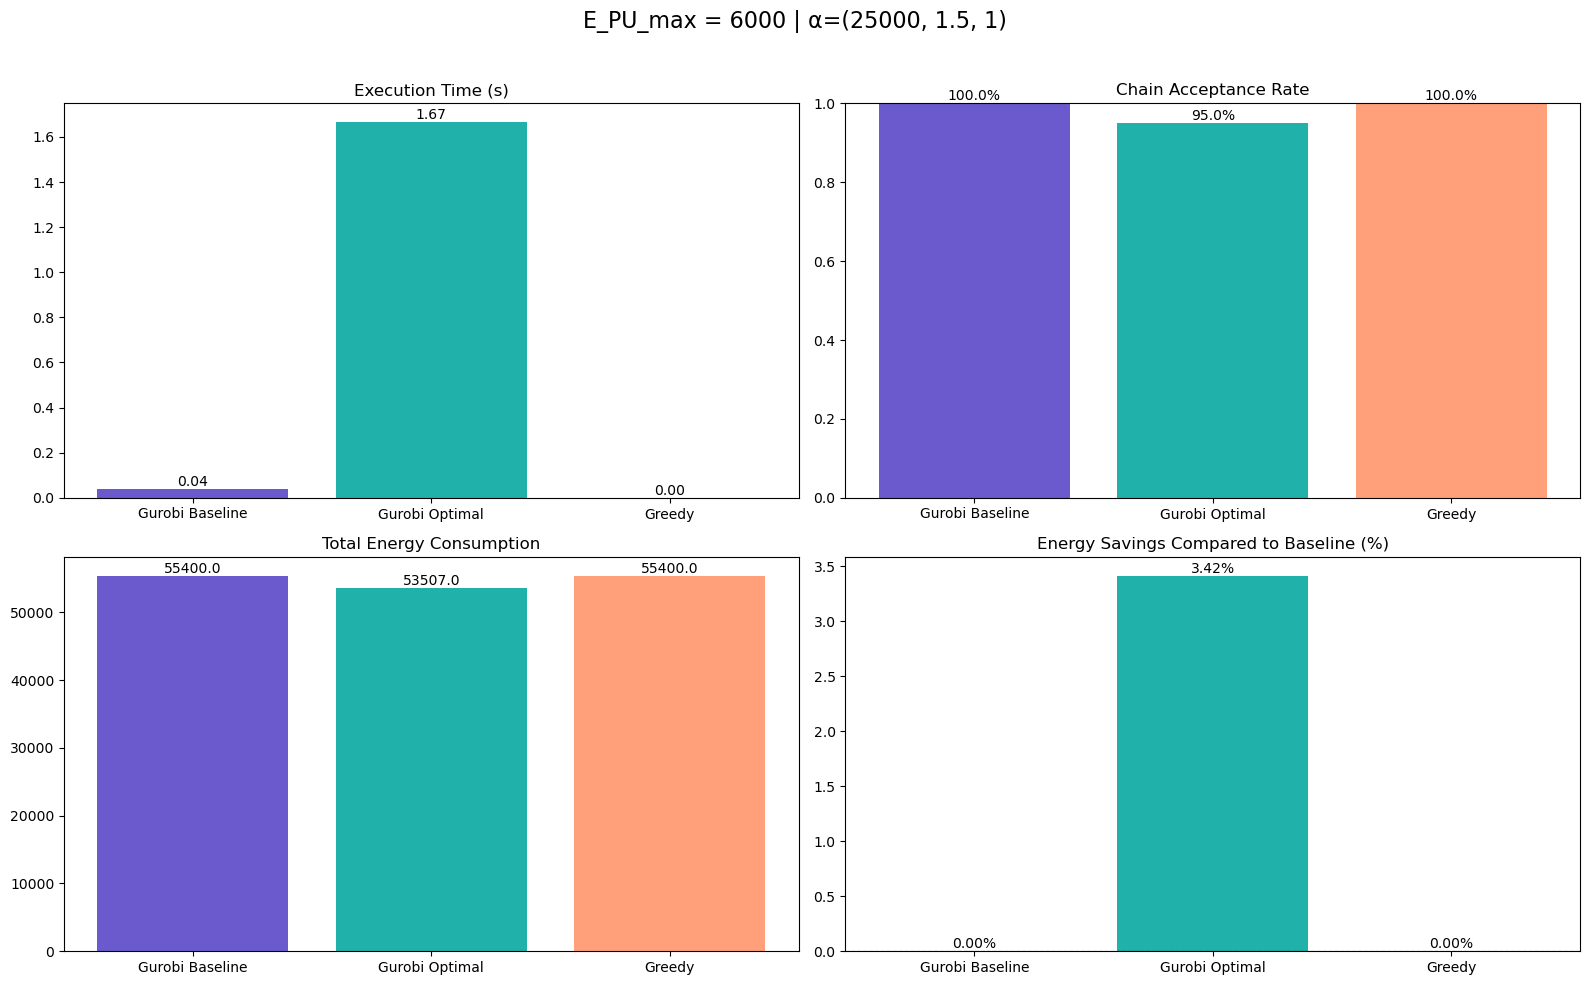

In [8]:
# alpha_1=25000.0, alpha_2=1.5, alpha_3=1.0

alpha_combination_1 = [
    (25000, 1.5, 1)  
]



all_results_1 = run_all_models(E_PU_max_list, alpha_combination_1)

plot_model(all_results_1)

Test Data: alpha=(30000, 2, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
⏱️ Gurobi Runtime: 0.17 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ❌ Not activated, Tasks: [58, 59, 60]
Chain 7: ❌ Not activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 74, 75]
Chain 12: ❌ Not activated, Tasks: [76, 77, 78]
Chain 13: ❌ Not activated, Tasks: [79, 80, 81]
Chain 14: ❌ Not activated, Tasks

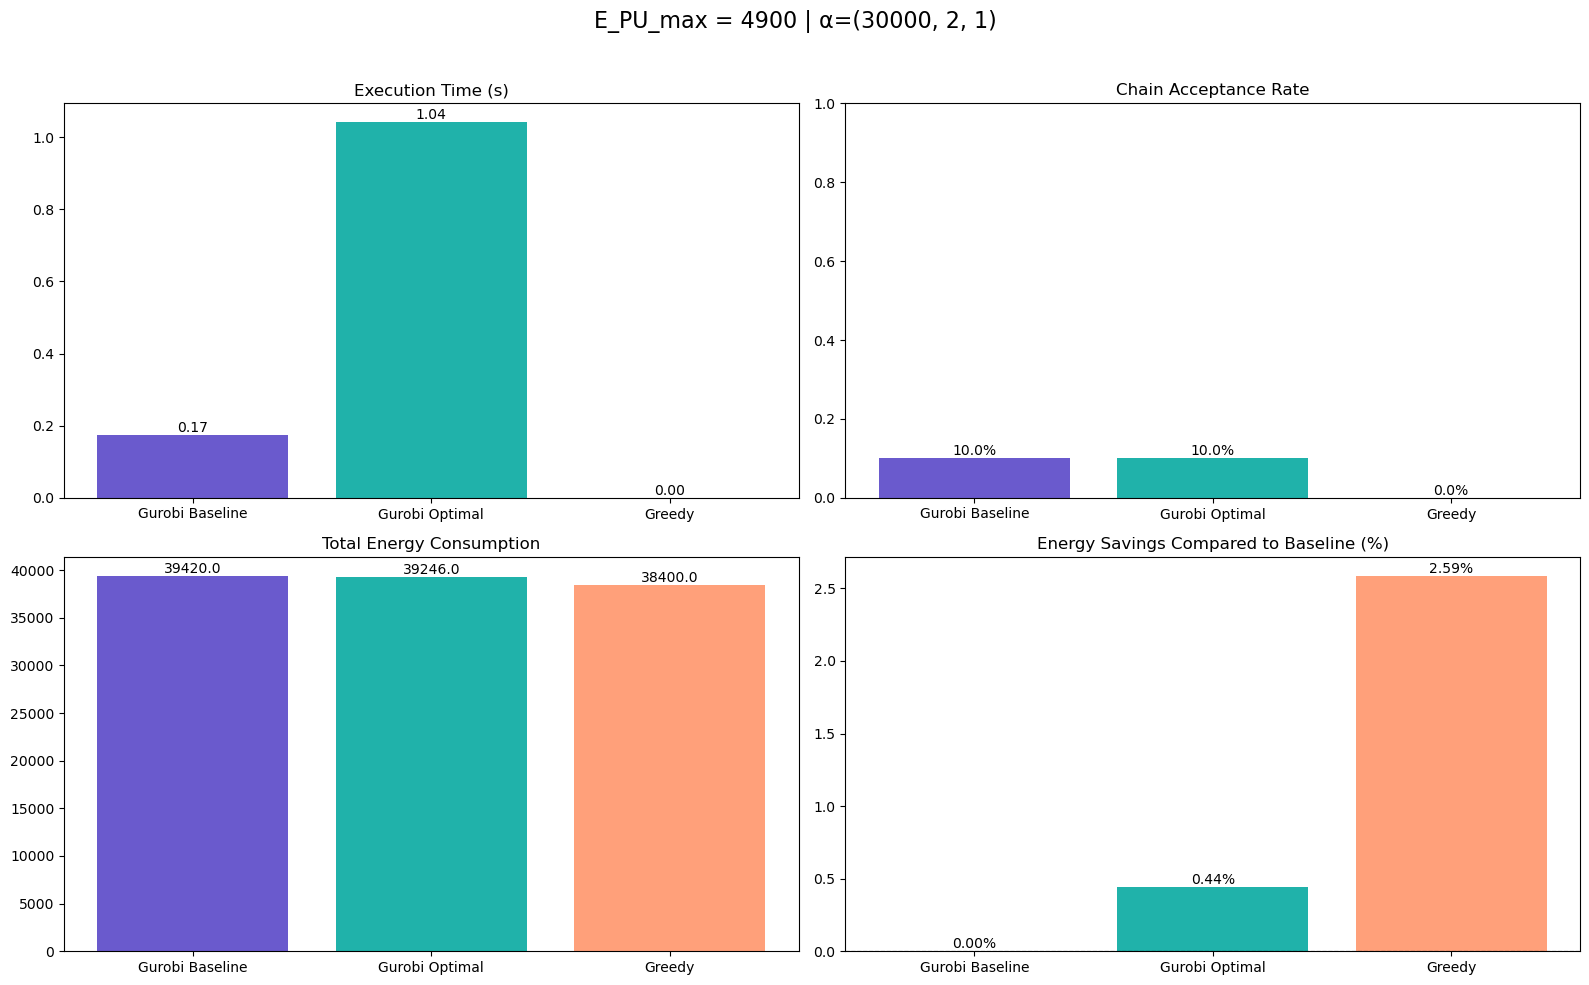

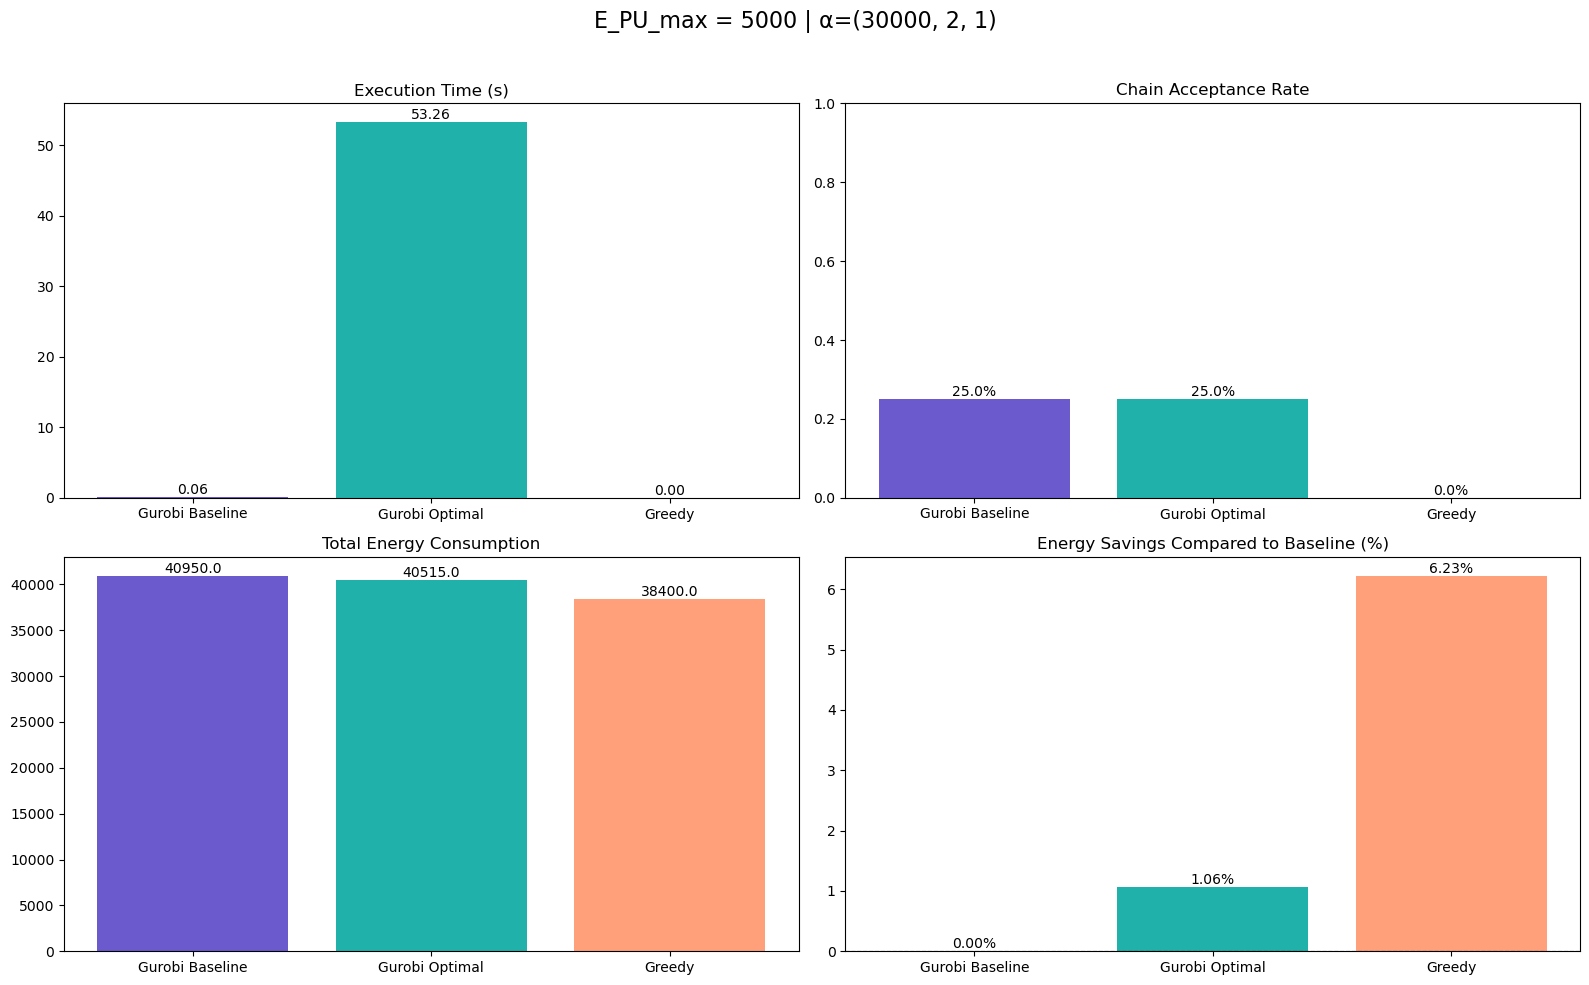

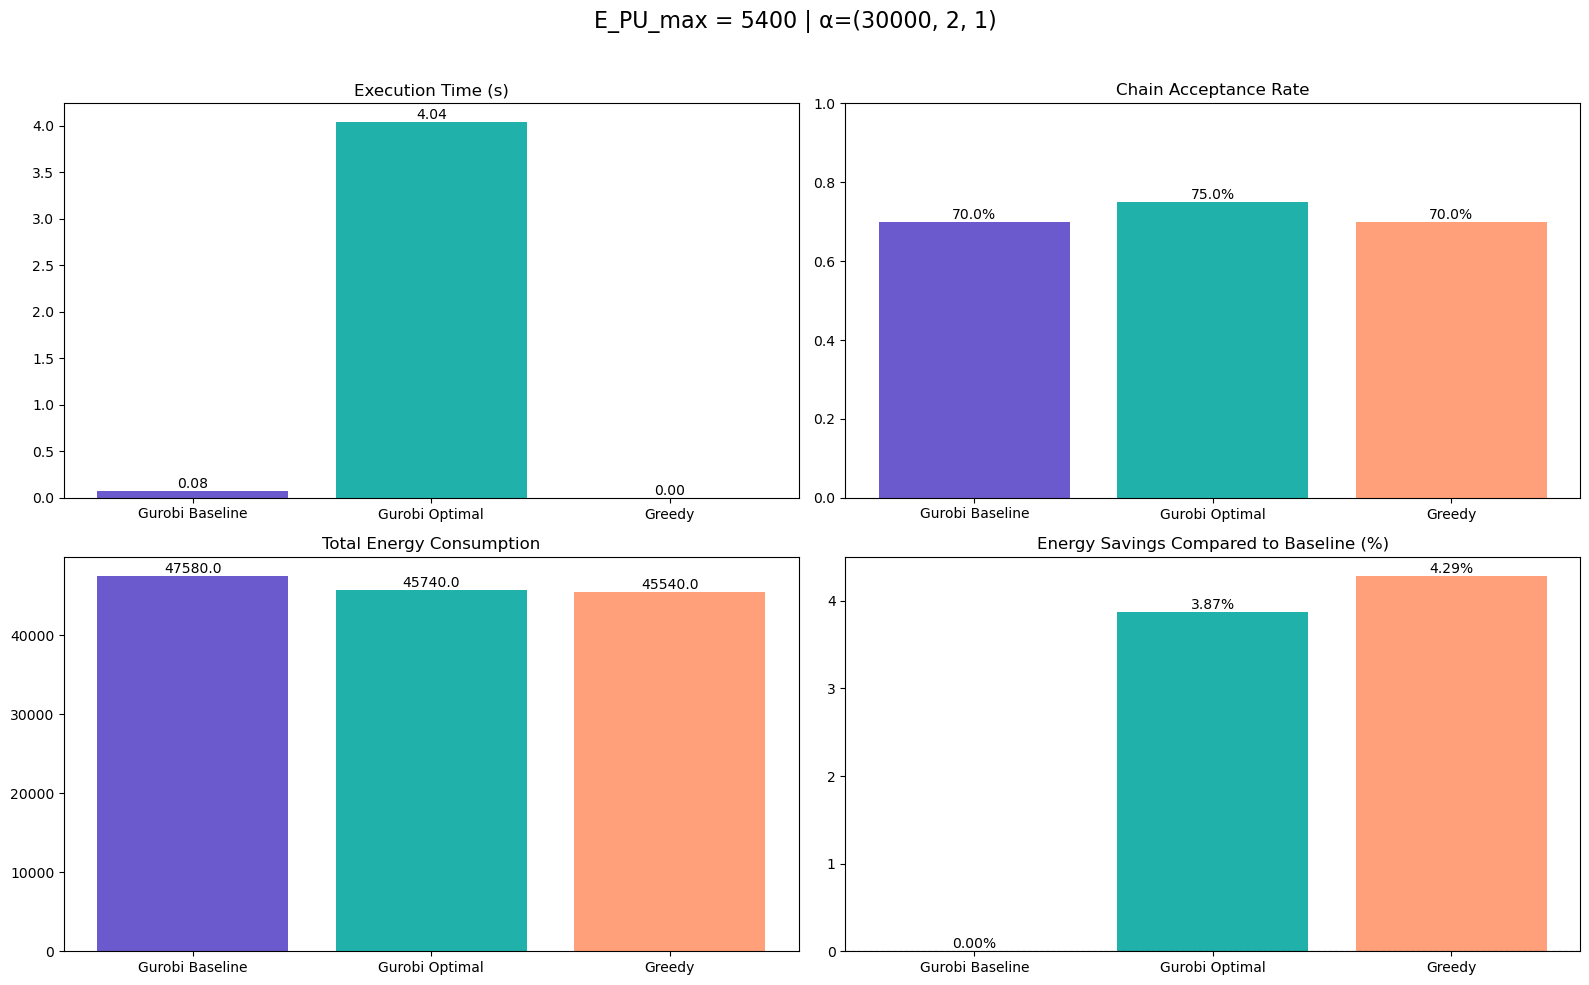

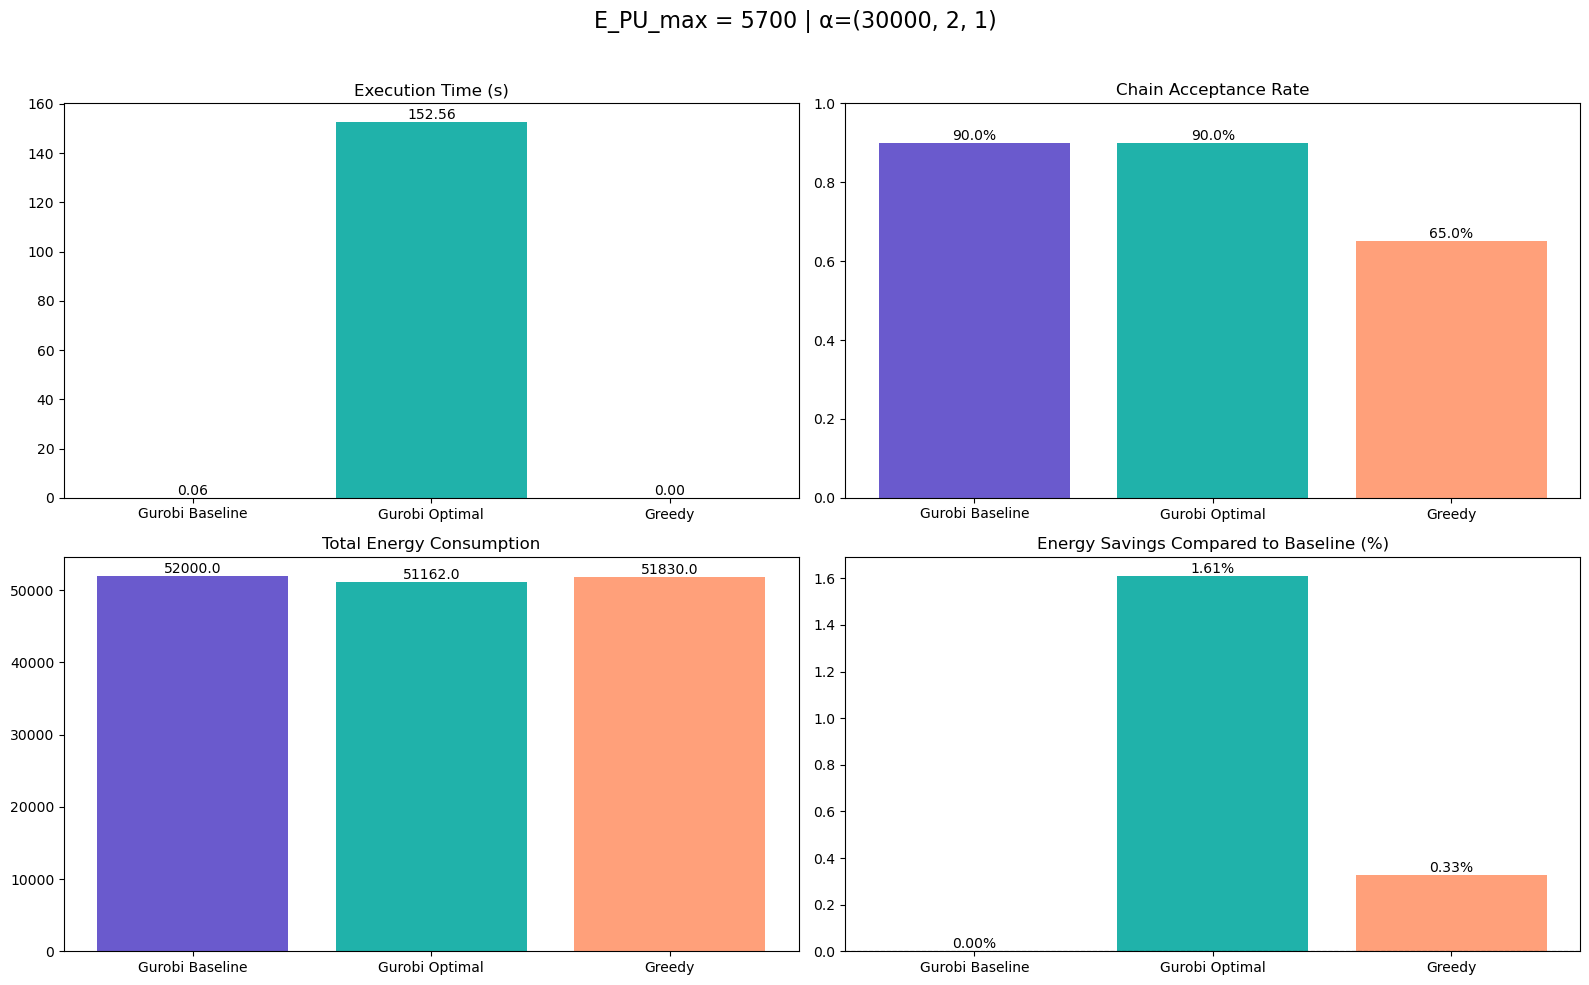

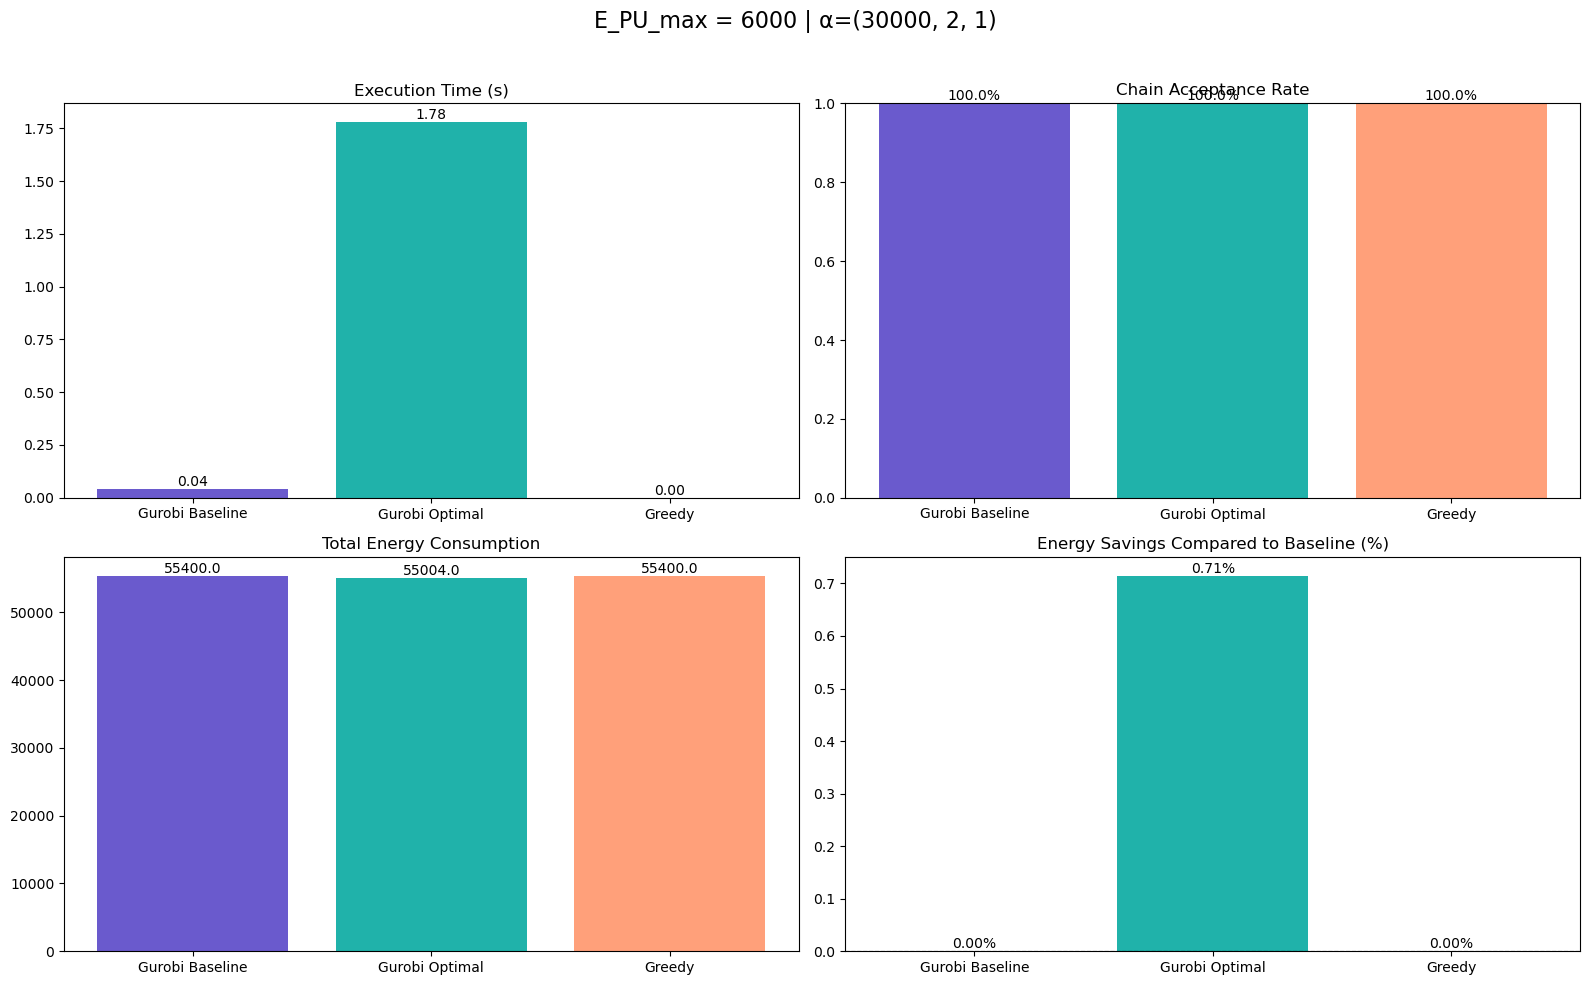

In [9]:
# alpha_1=30000.0, alpha_2=1.5, alpha_3=1.0

alpha_combination_2 = [
    (30000, 2, 1)  
]



all_results_2 = run_all_models(E_PU_max_list, alpha_combination_2)

plot_model(all_results_2)

Test Data: alpha=(35000, 2, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
⏱️ Gurobi Runtime: 0.12 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ❌ Not activated, Tasks: [58, 59, 60]
Chain 7: ❌ Not activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 74, 75]
Chain 12: ❌ Not activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ❌ Not activated, Tasks: [8

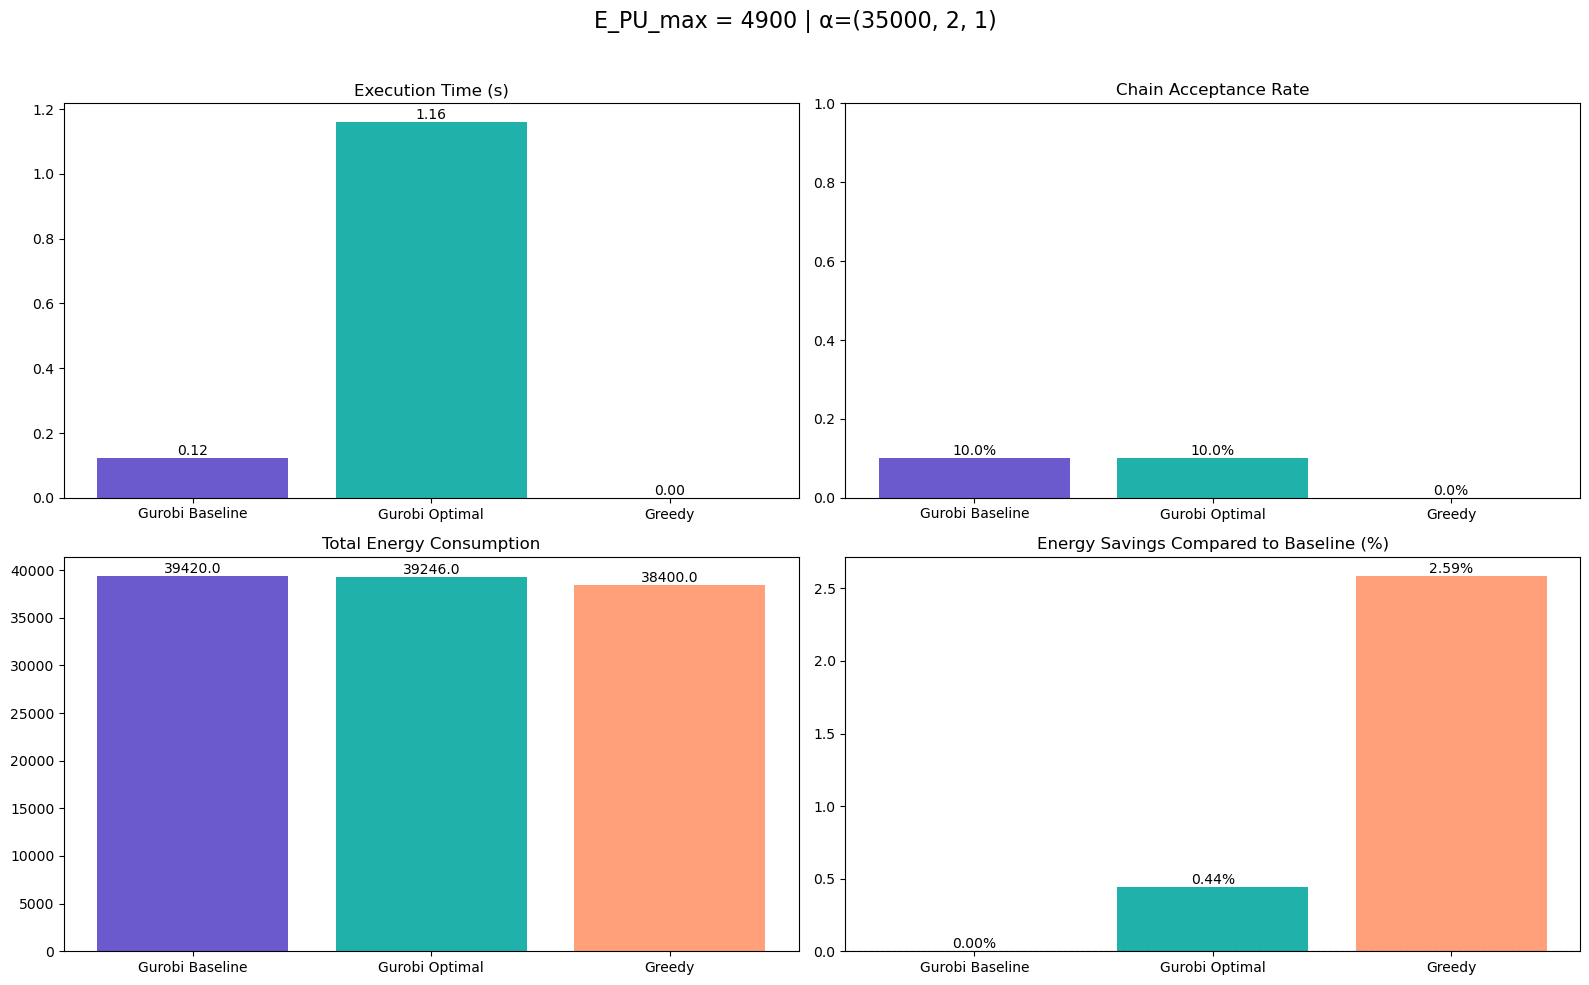

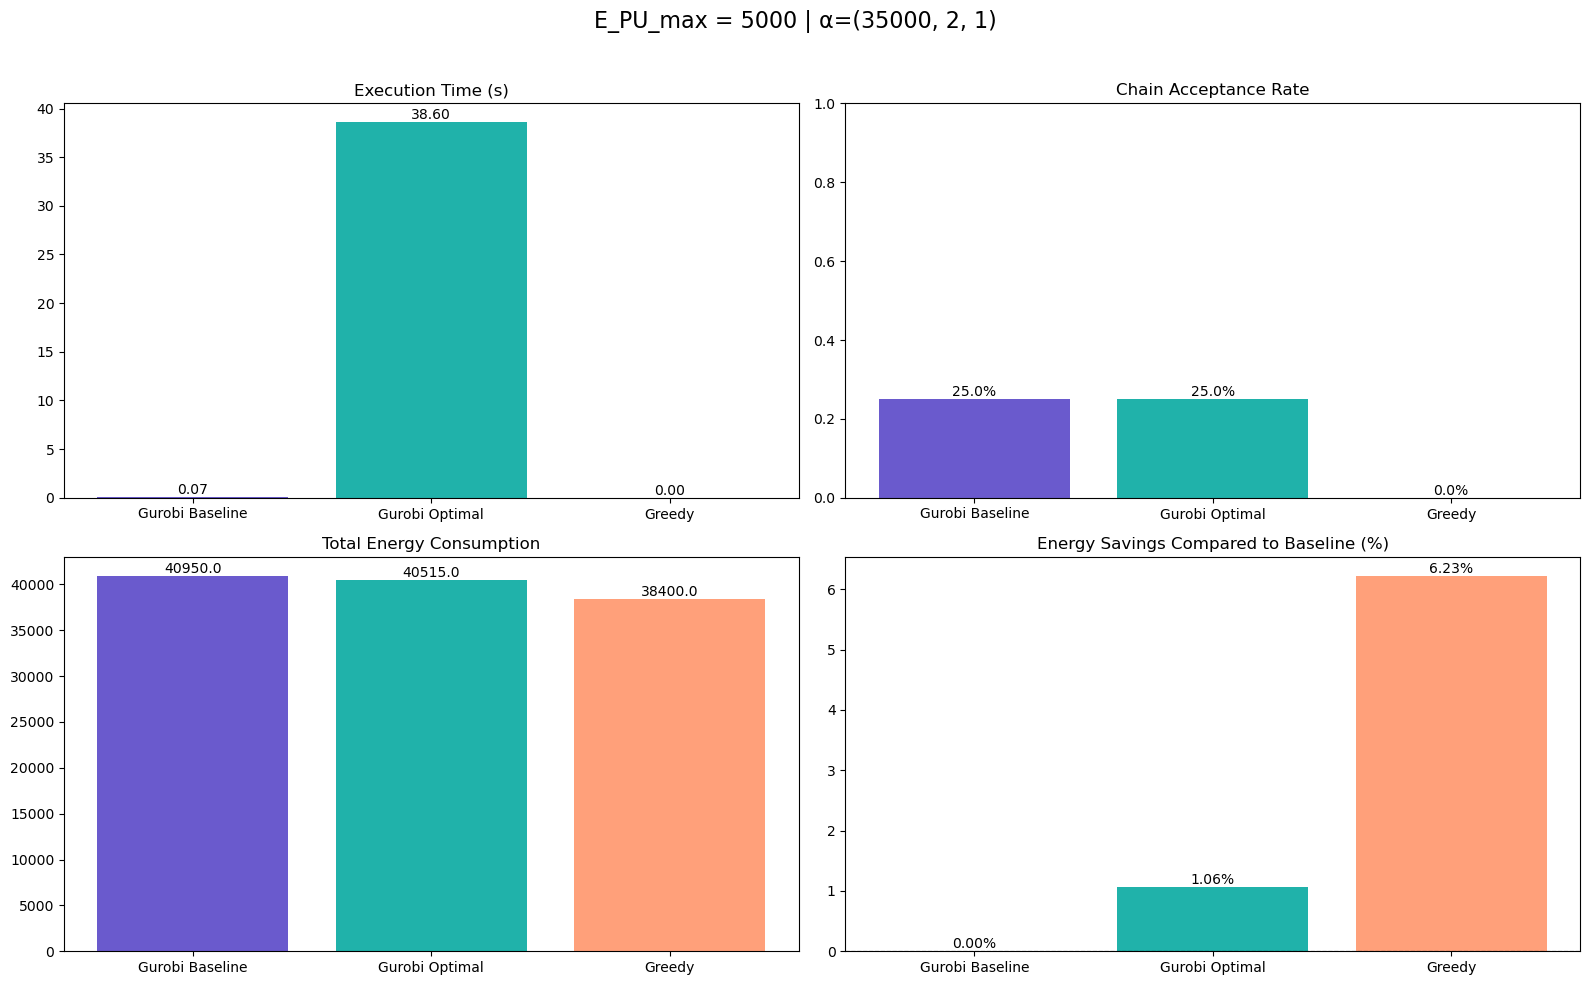

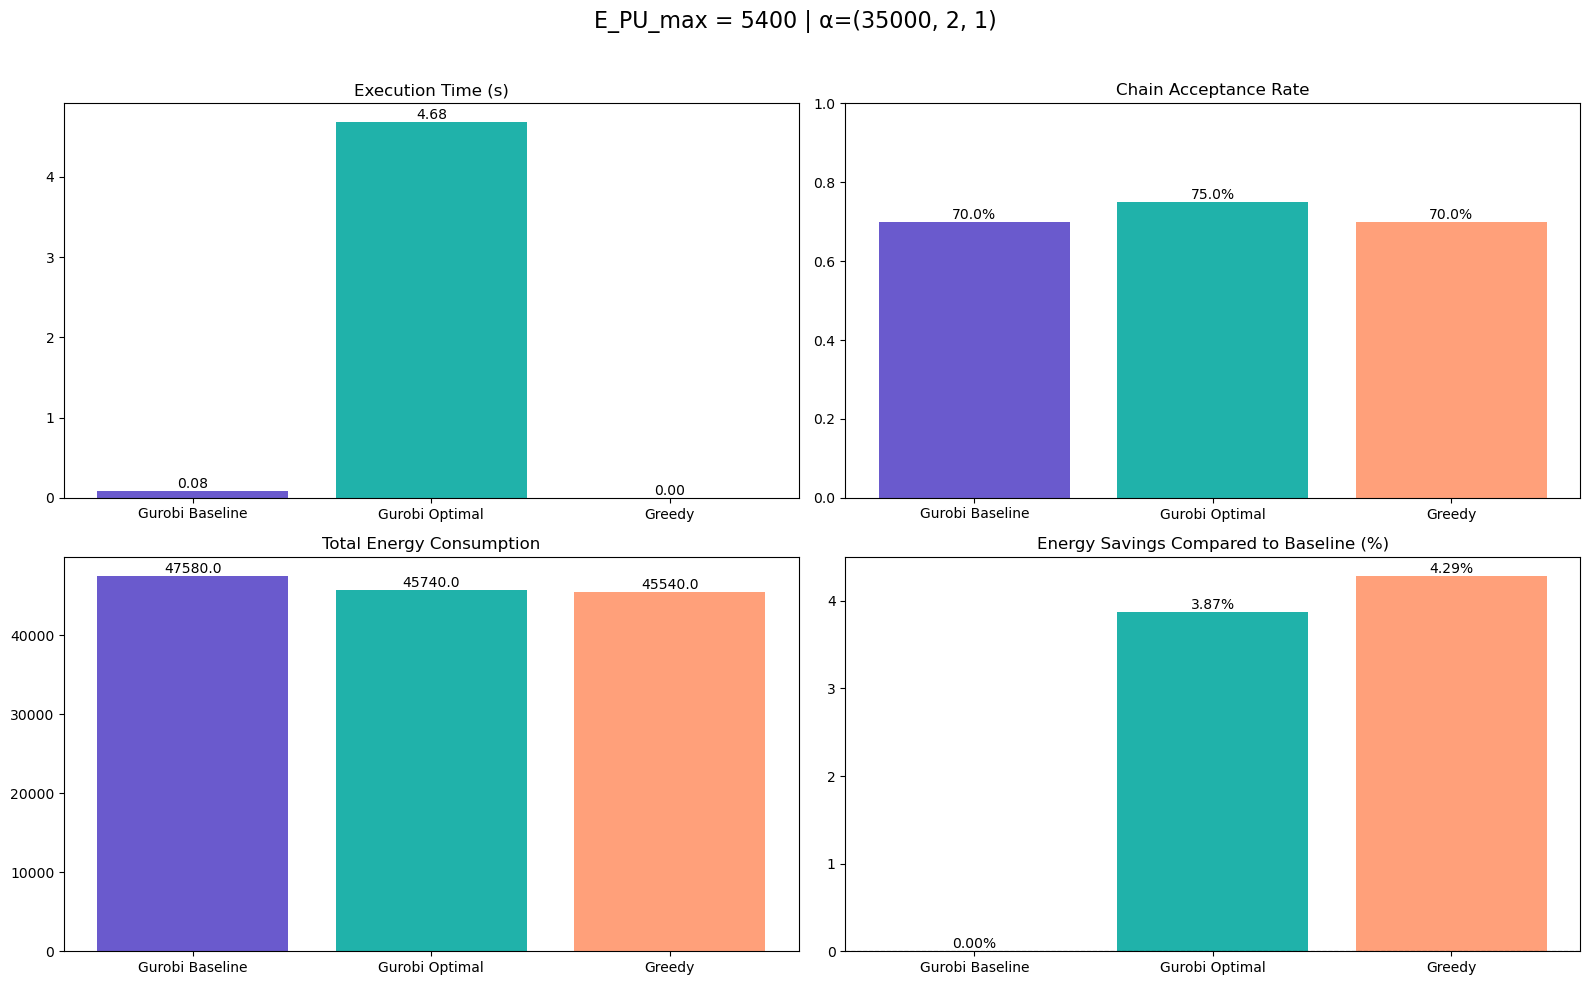

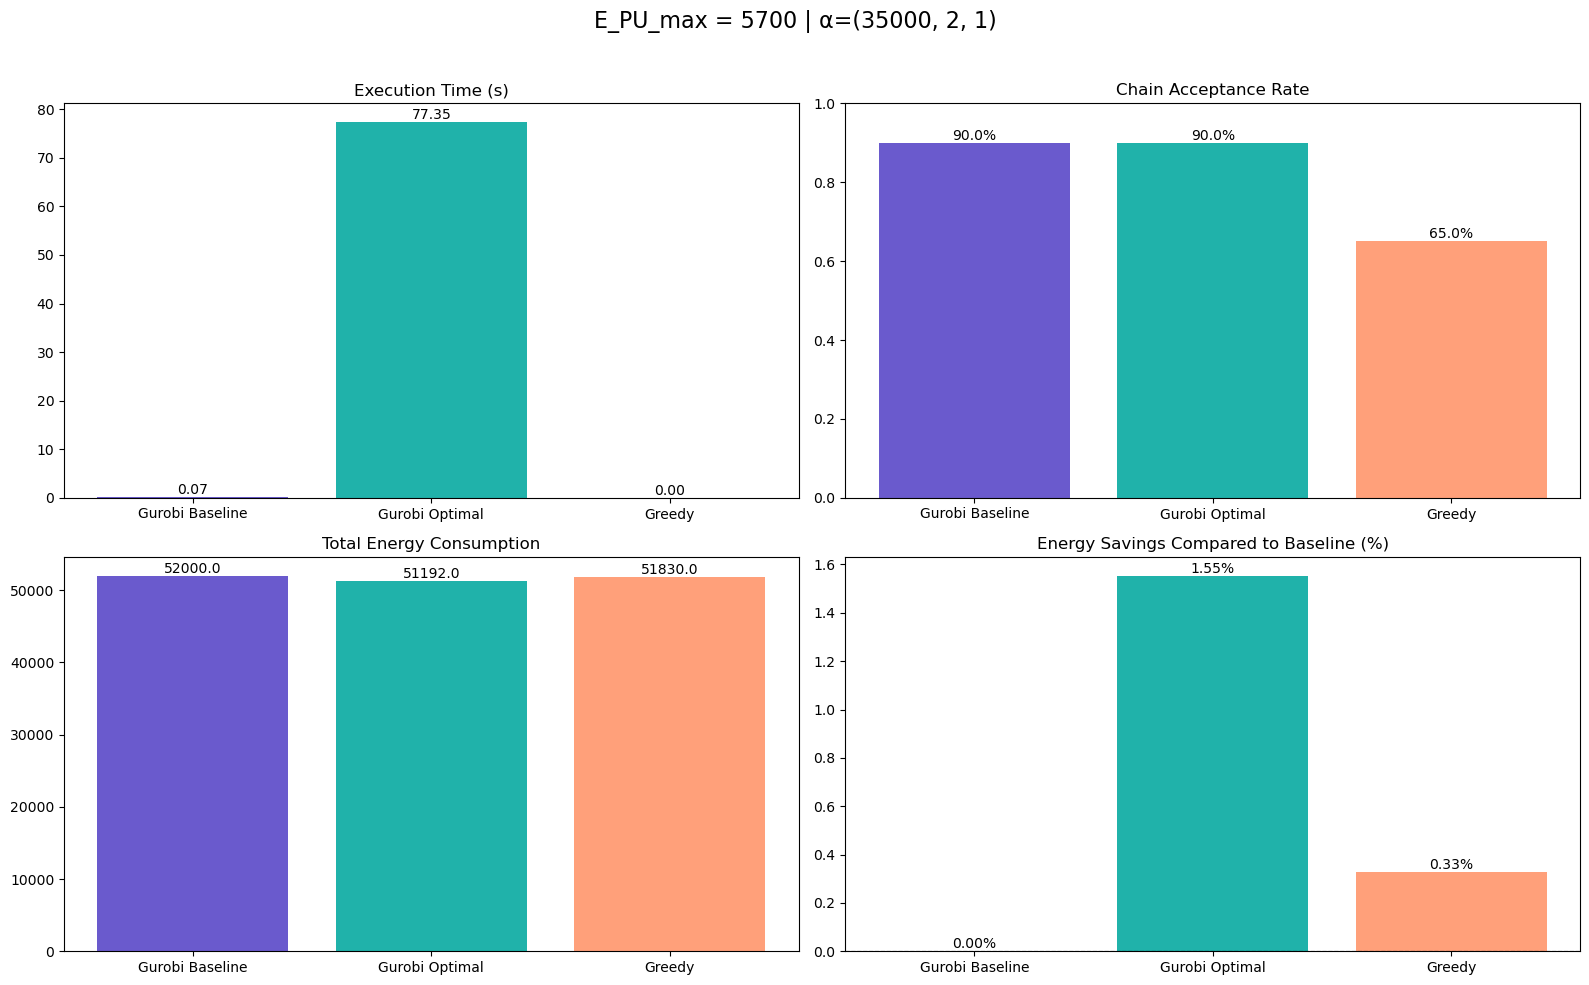

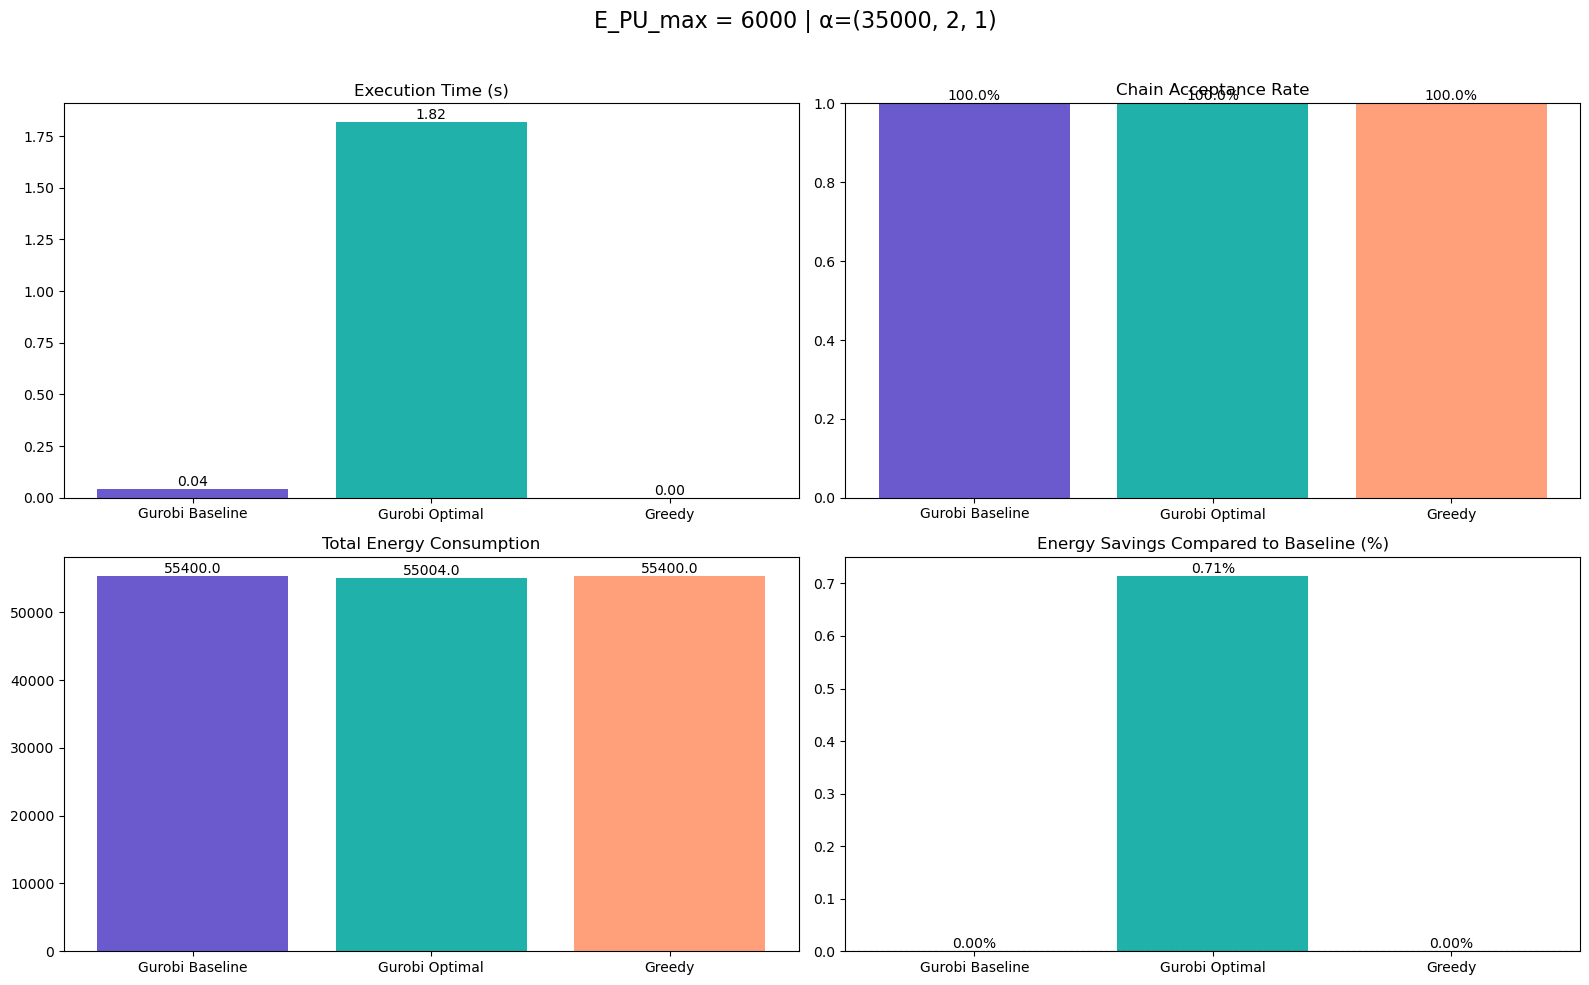

In [10]:
# alpha_1=35000.0, alpha_2=1.5, alpha_3=1.0

alpha_combination_3 = [
    (35000, 2, 1)  
]



all_results_3 = run_all_models(E_PU_max_list, alpha_combination_3)

plot_model(all_results_3)

Test Data: alpha=(40000, 2, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
⏱️ Gurobi Runtime: 0.11 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 74, 75]
Chain 12: ❌ Not activated, Tasks: [76, 77, 78]
Chain 13: ❌ Not activated, Tasks: [79, 80, 81]
Chain 14: ❌ Not activated, Tasks: [82, 8

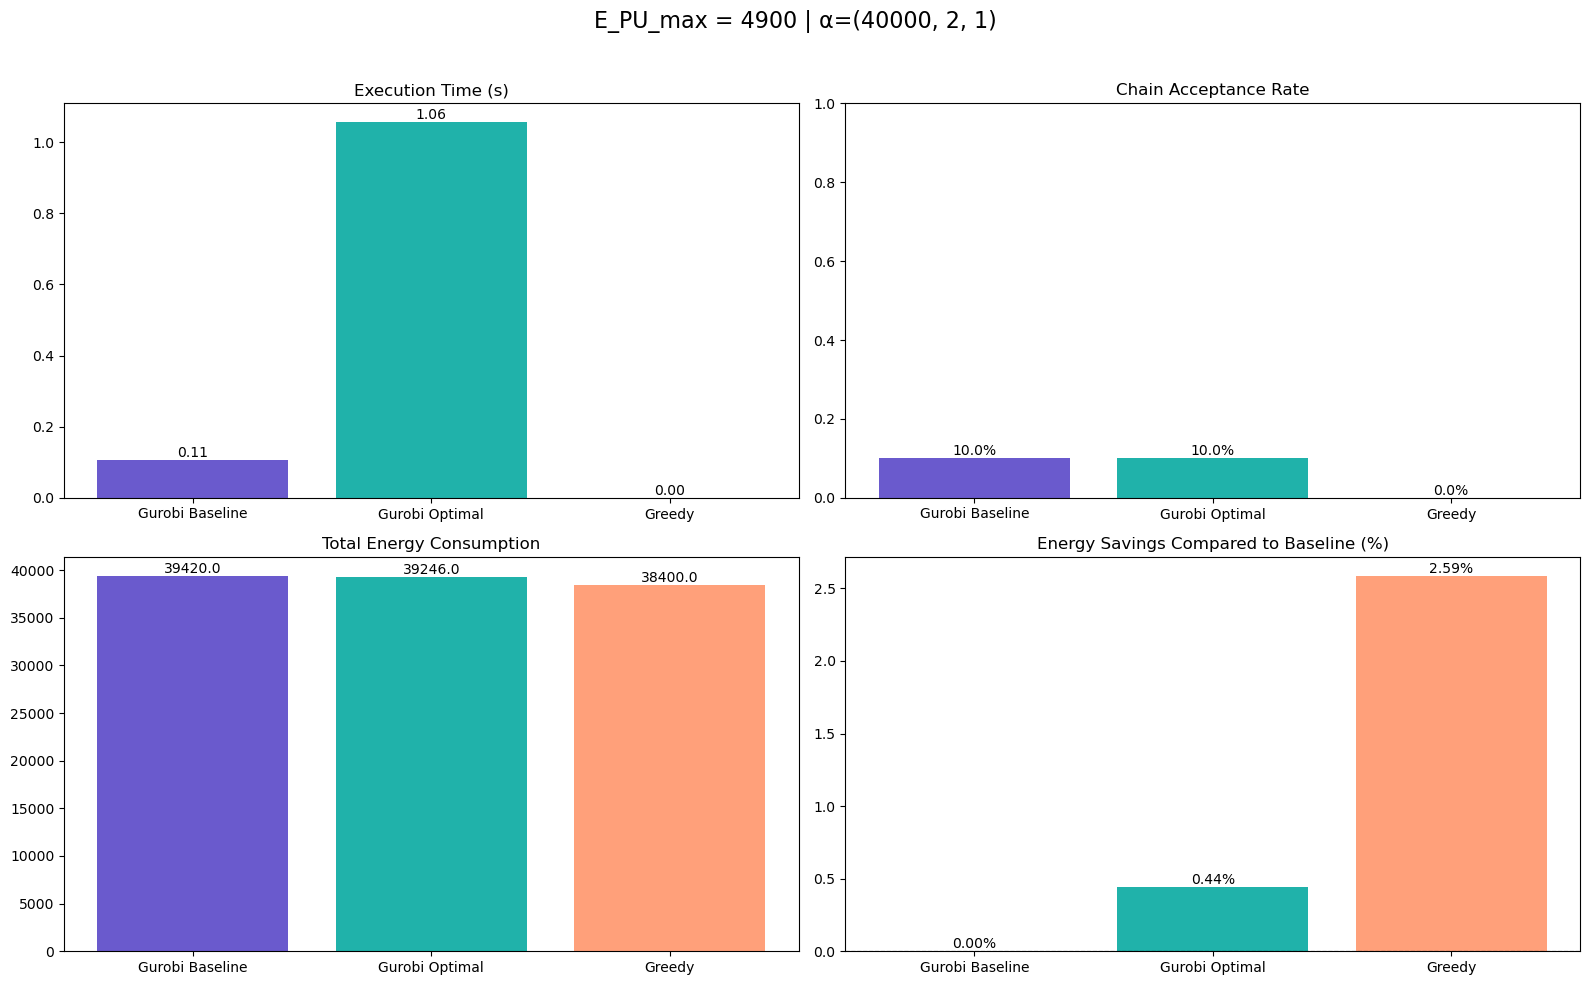

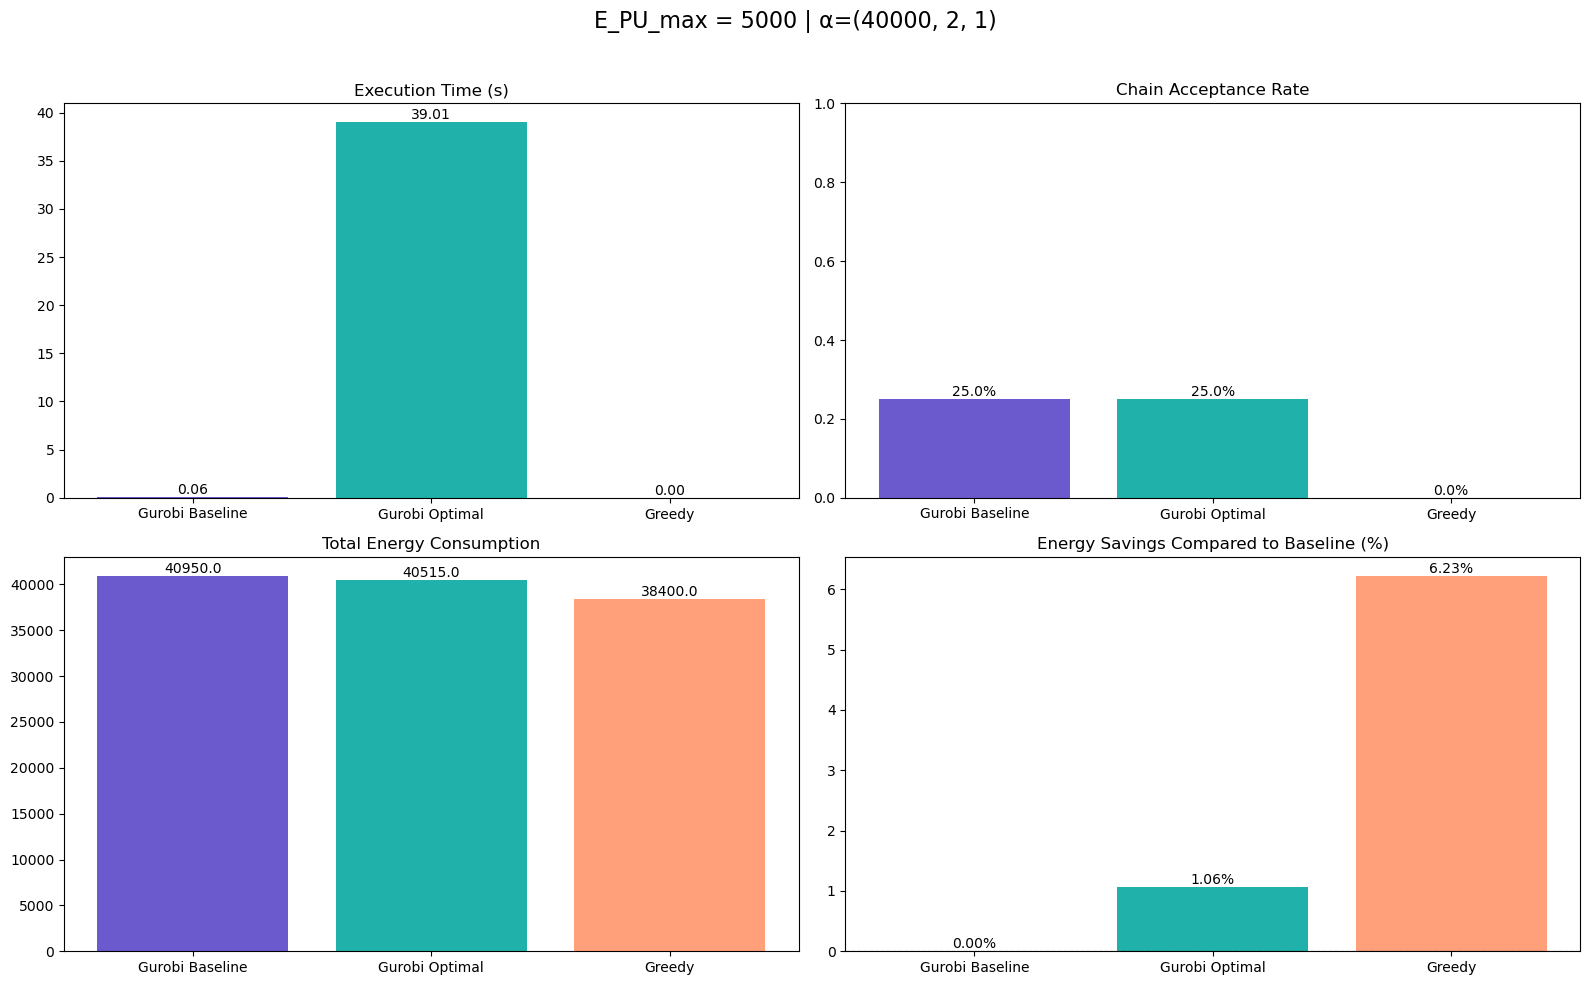

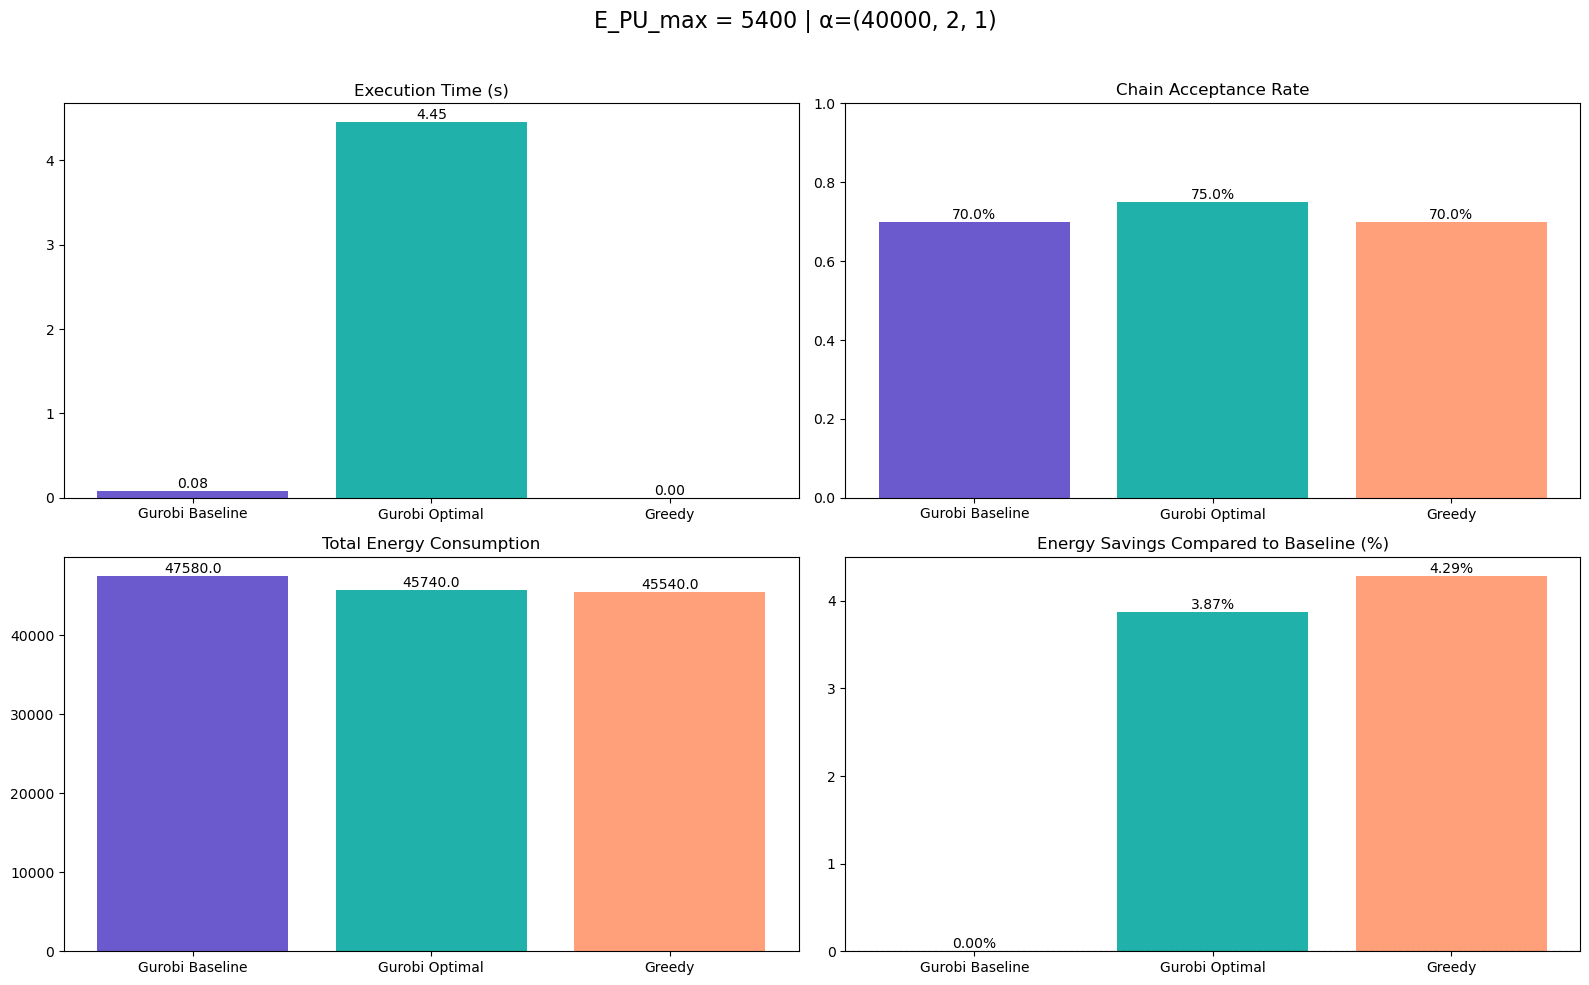

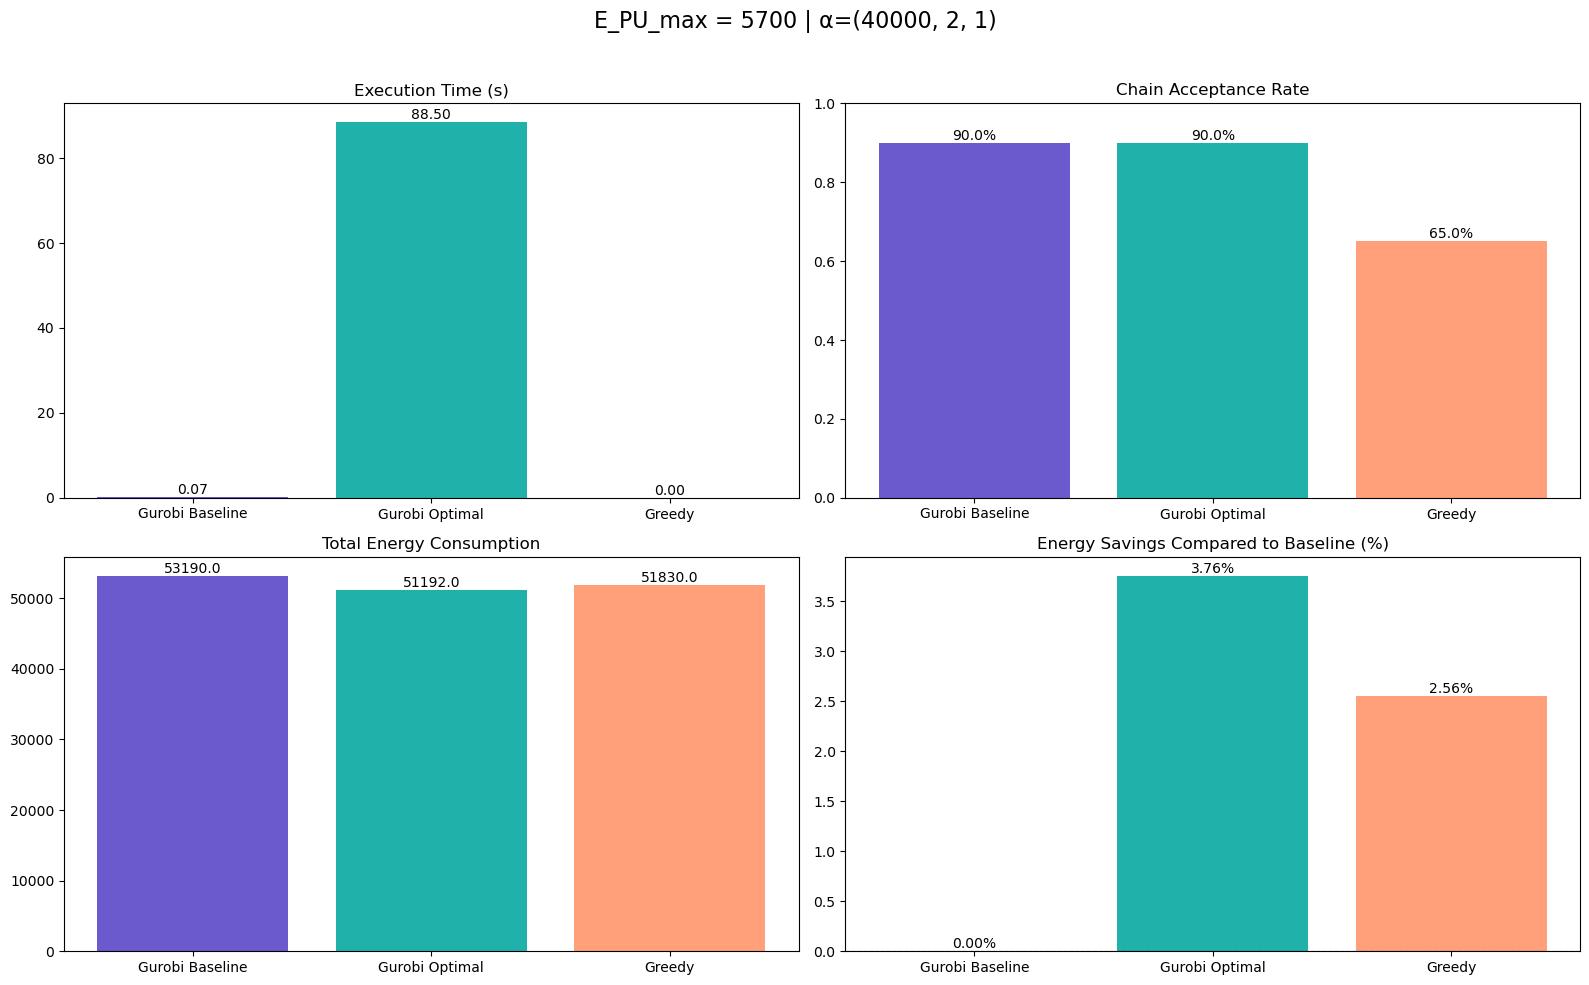

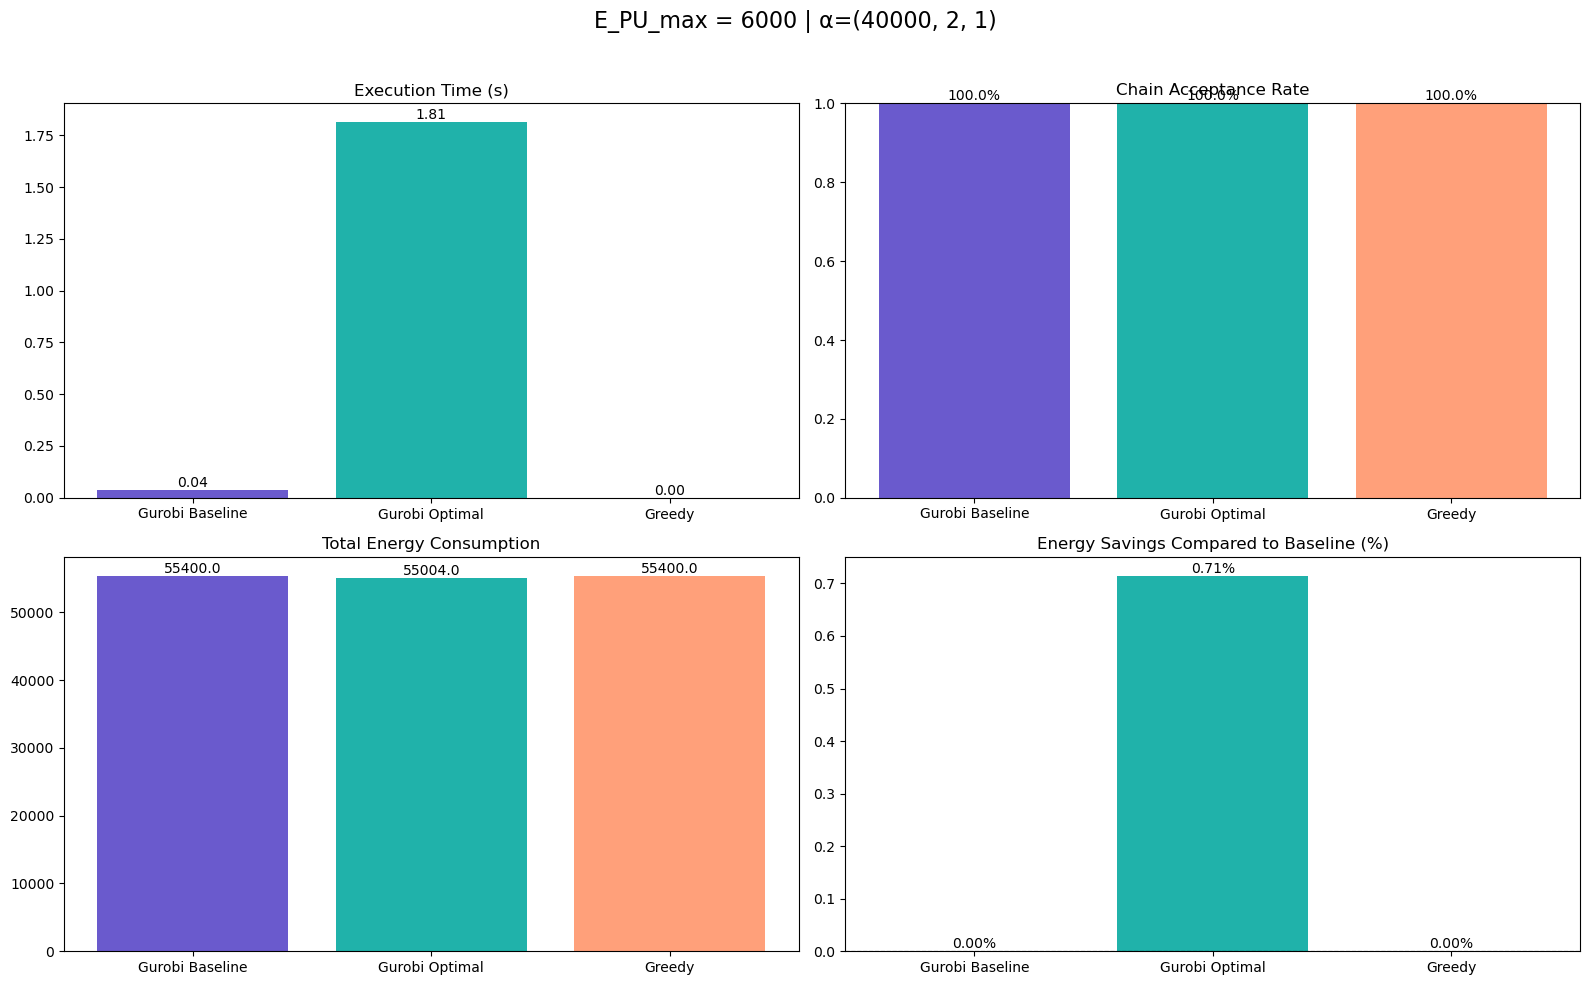

In [12]:
# alpha_1=40000.0, alpha_2=2, alpha_3=1.0

alpha_combination_3 = [
    (40000, 2, 1)  
]



all_results_3 = run_all_models(E_PU_max_list, alpha_combination_3)

plot_model(all_results_3)

Test Data: alpha=(40000, 3, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
⏱️ Gurobi Runtime: 0.11 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 74, 75]
Chain 12: ❌ Not activated, Tasks: [76, 77, 78]
Chain 13: ❌ Not activated, Tasks: [79, 80, 81]
Chain 14: ❌ Not activated, Tasks: [82, 8

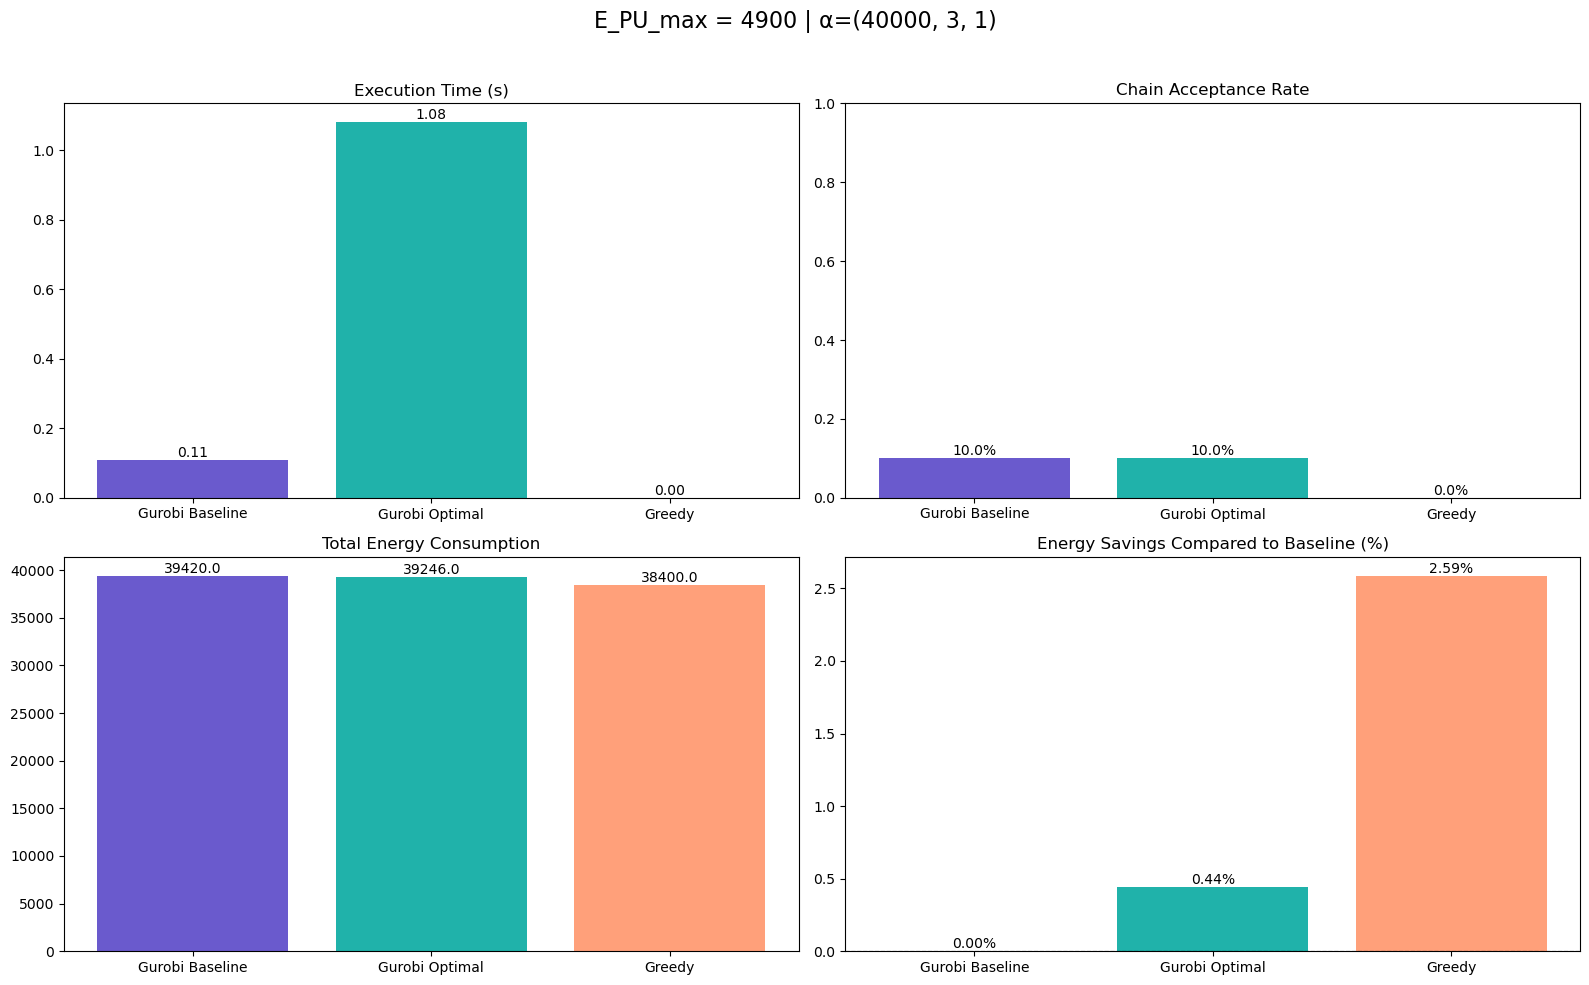

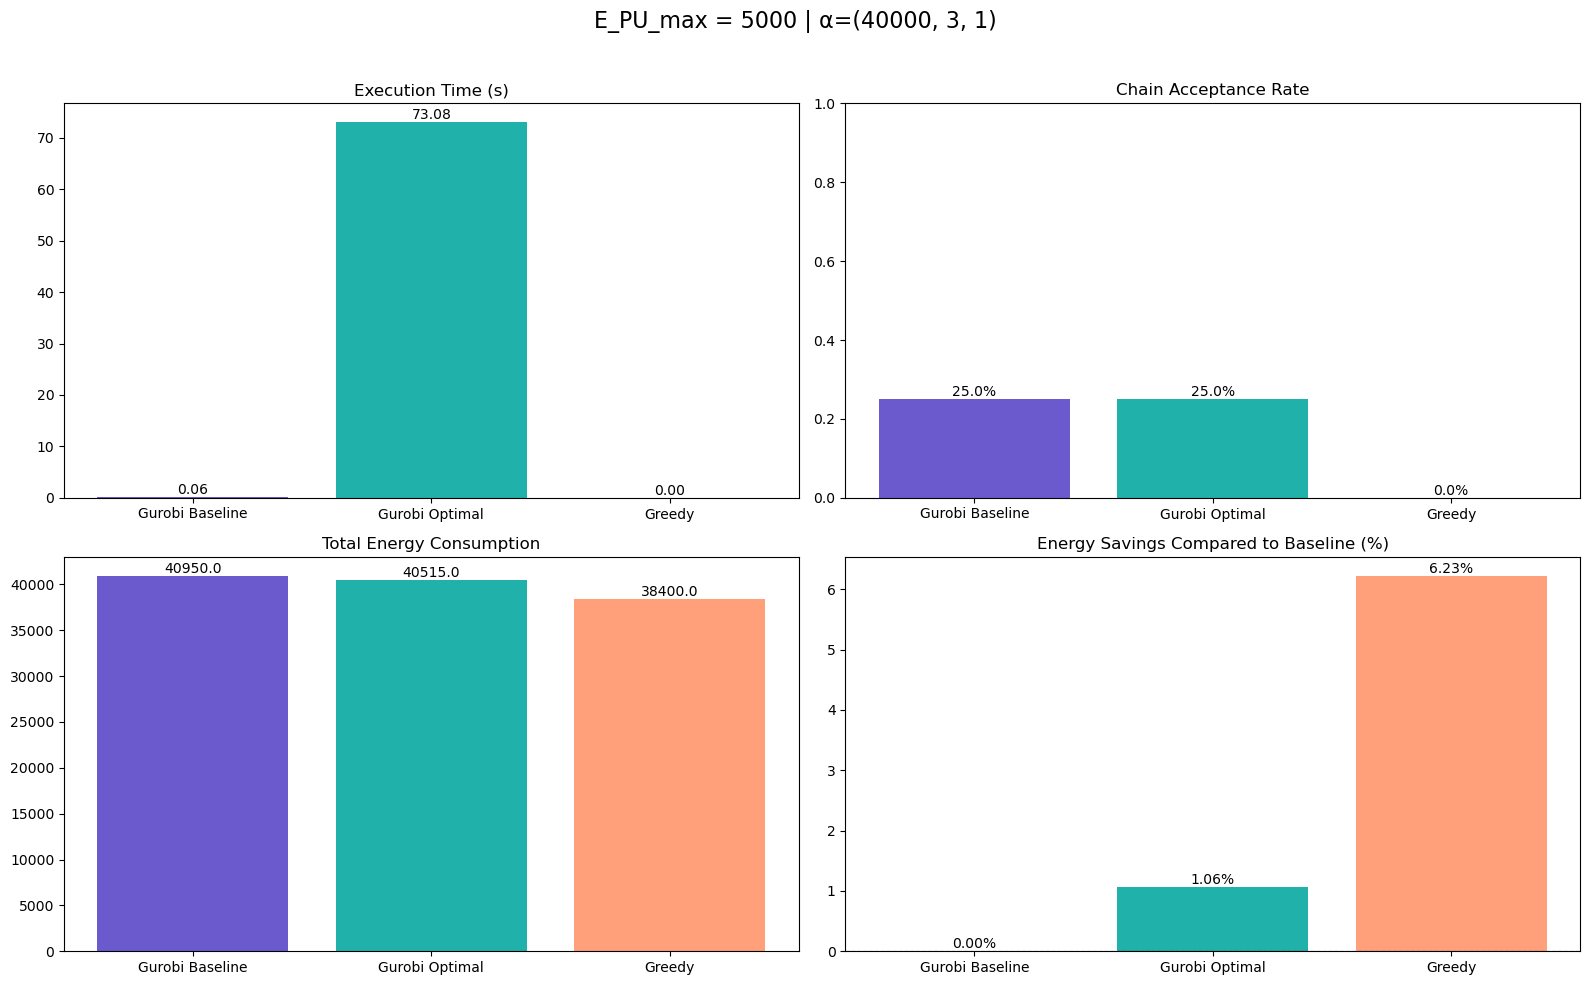

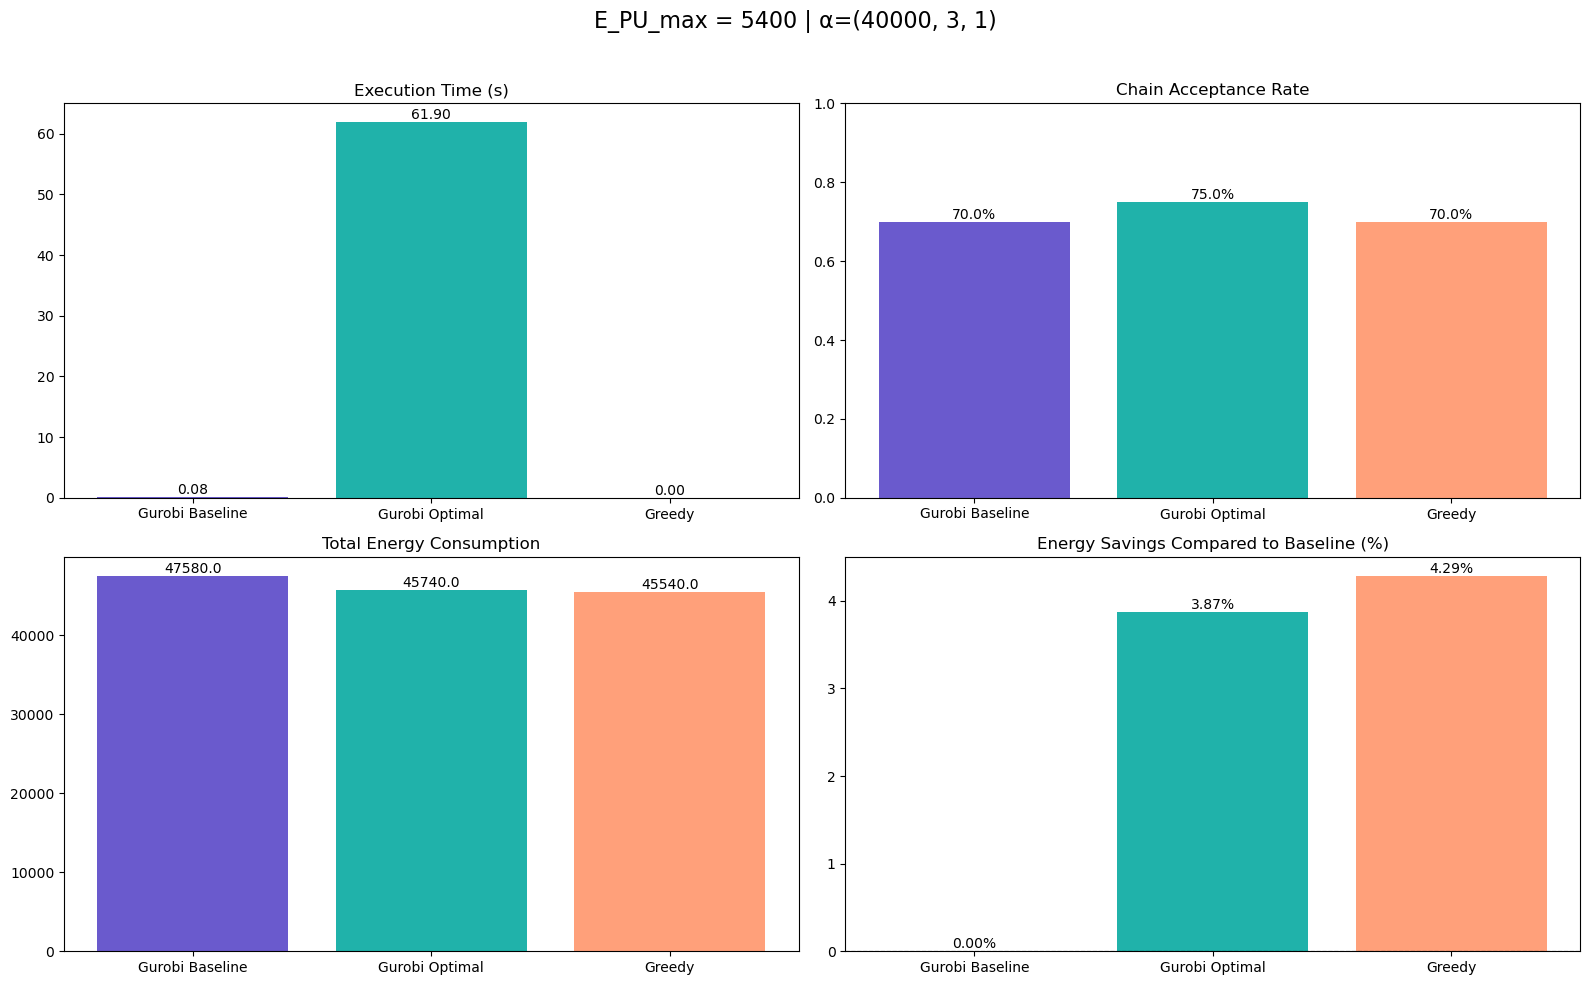

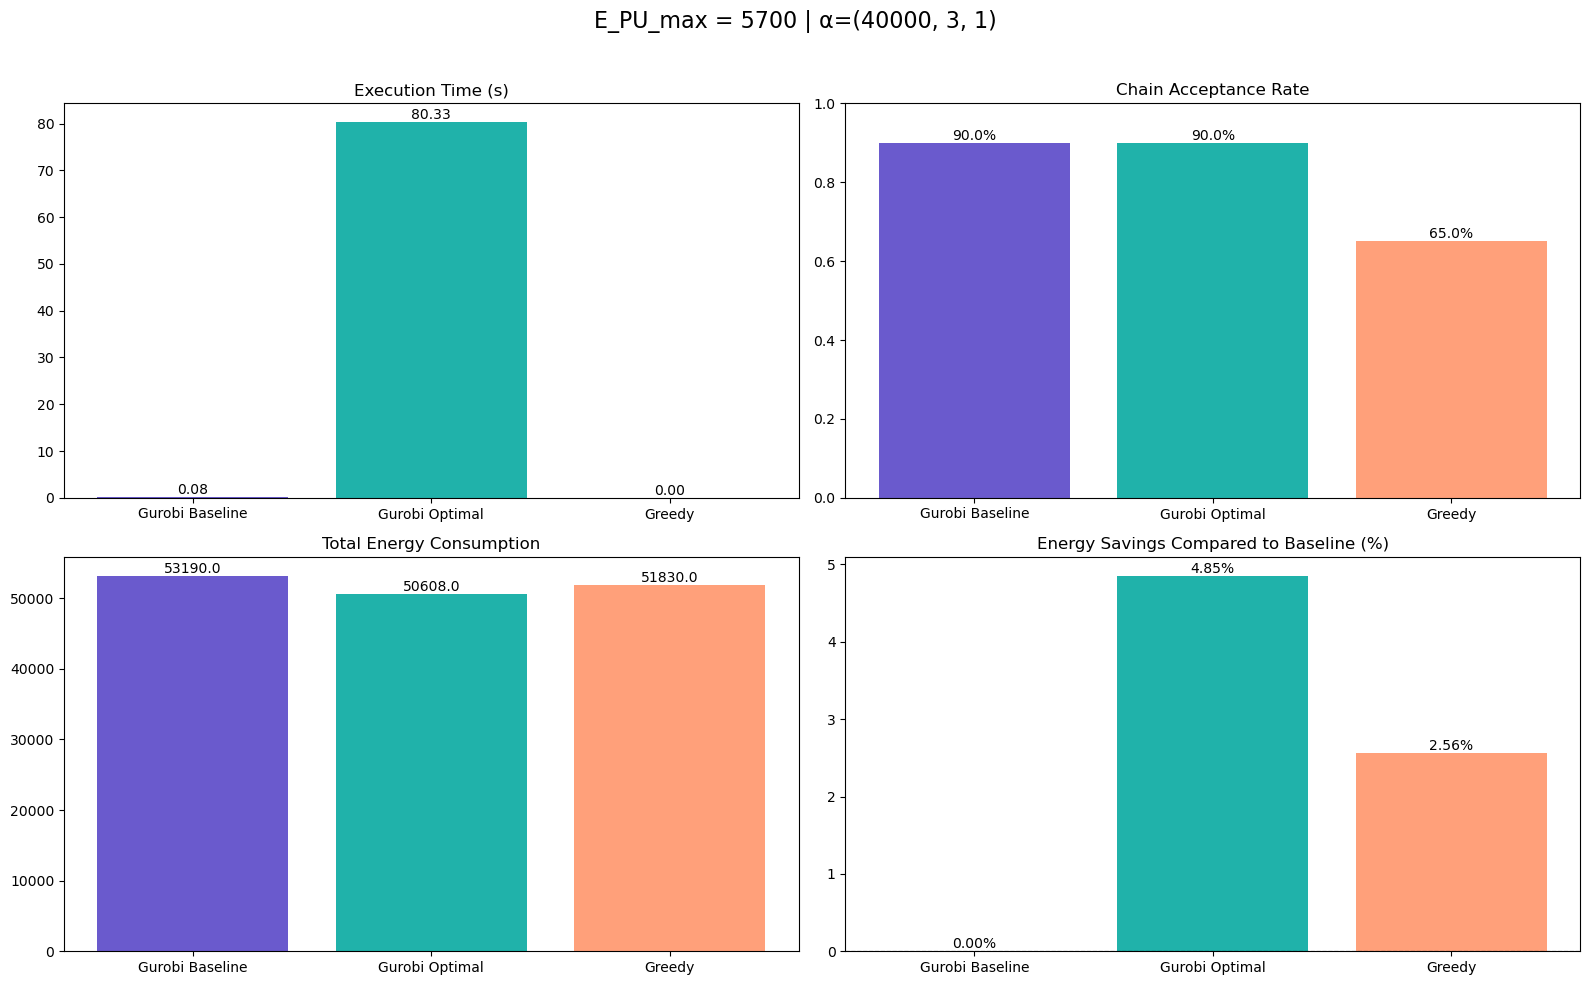

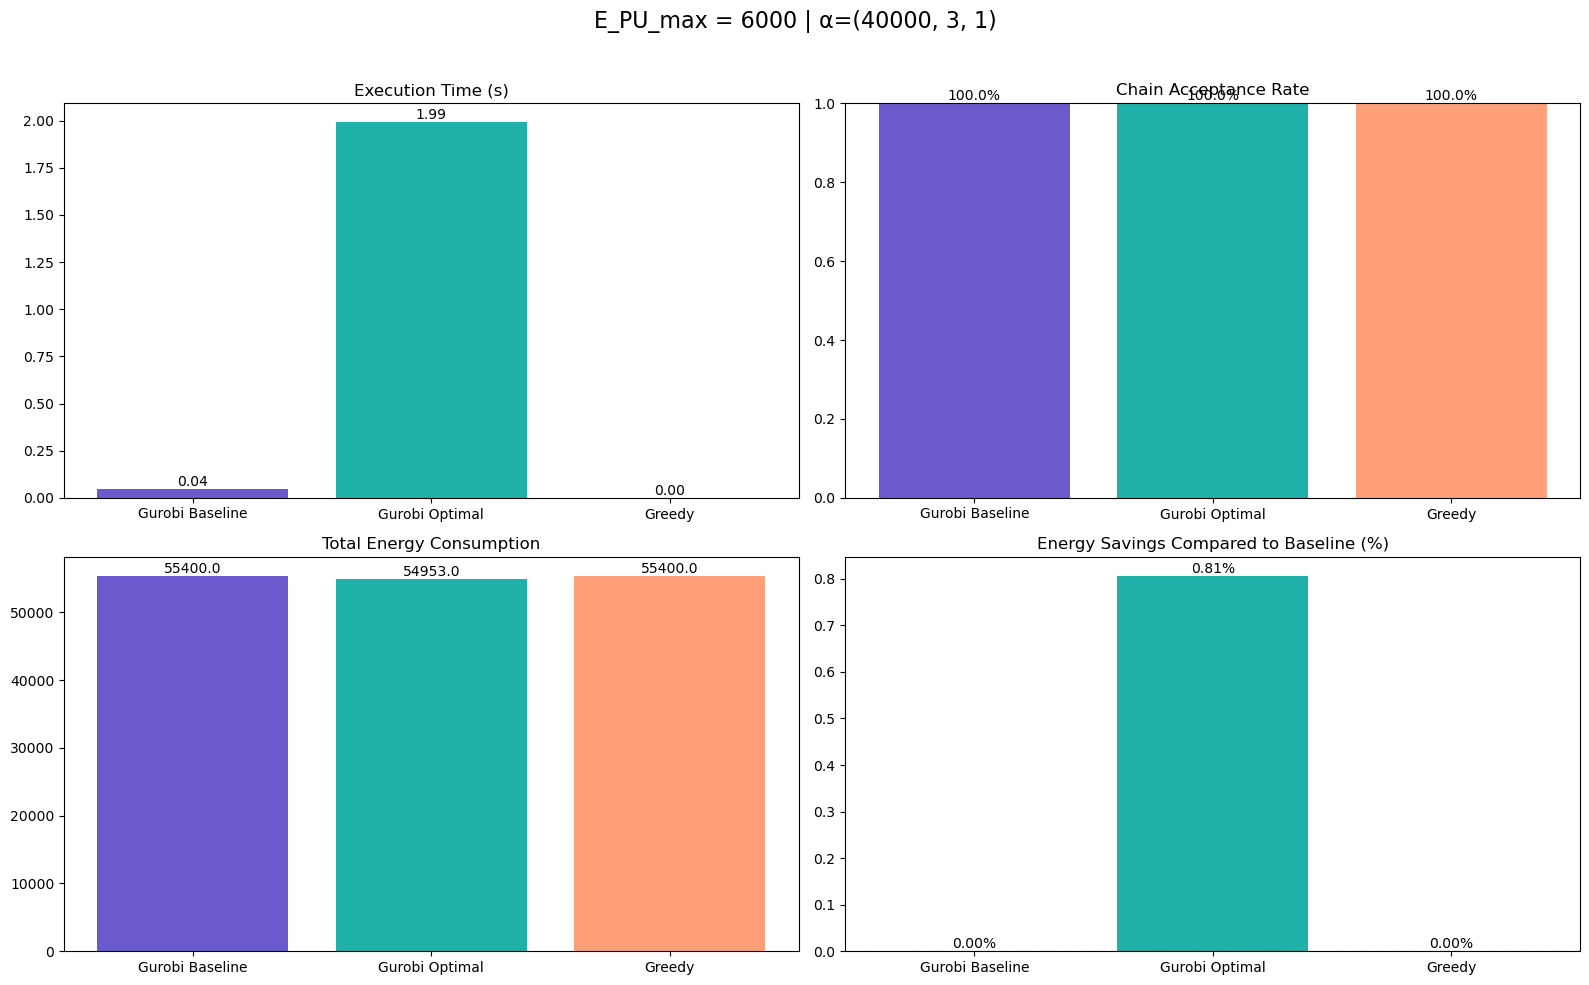

In [13]:
# alpha_1=40000.0, alpha_2=3, alpha_3=1.0

alpha_combination_4 = [
    (40000, 3, 1)  
]



all_results_4 = run_all_models(E_PU_max_list, alpha_combination_4)

plot_model(all_results_4)

Test Data: alpha=(45000, 3, 1), E_PU_max=[4900, 4900, 4900, 4900, 4900, 4900, 4900, 4900]
Gurobi [Baseline]
⏱️ Gurobi Runtime: 0.13 seconds

📋 Chain Activation Overview:
Chain 0: ❌ Not activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ❌ Not activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ❌ Not activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ❌ Not activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ❌ Not activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ❌ Not activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ❌ Not activated, Tasks: [58, 59, 60]
Chain 7: ❌ Not activated, Tasks: [61, 62, 63]
Chain 8: ❌ Not activated, Tasks: [64, 65, 66]
Chain 9: ❌ Not activated, Tasks: [67, 68, 69]
Chain 10: ❌ Not activated, Tasks: [70, 71, 72]
Chain 11: ❌ Not activated, Tasks: [73, 74, 75]
Chain 12: ❌ Not activated, Tasks: [76, 77, 78]
Chain 13: ❌ Not activated, Tasks: [79, 80, 81]
Chain 14: ❌ Not activated, Tasks

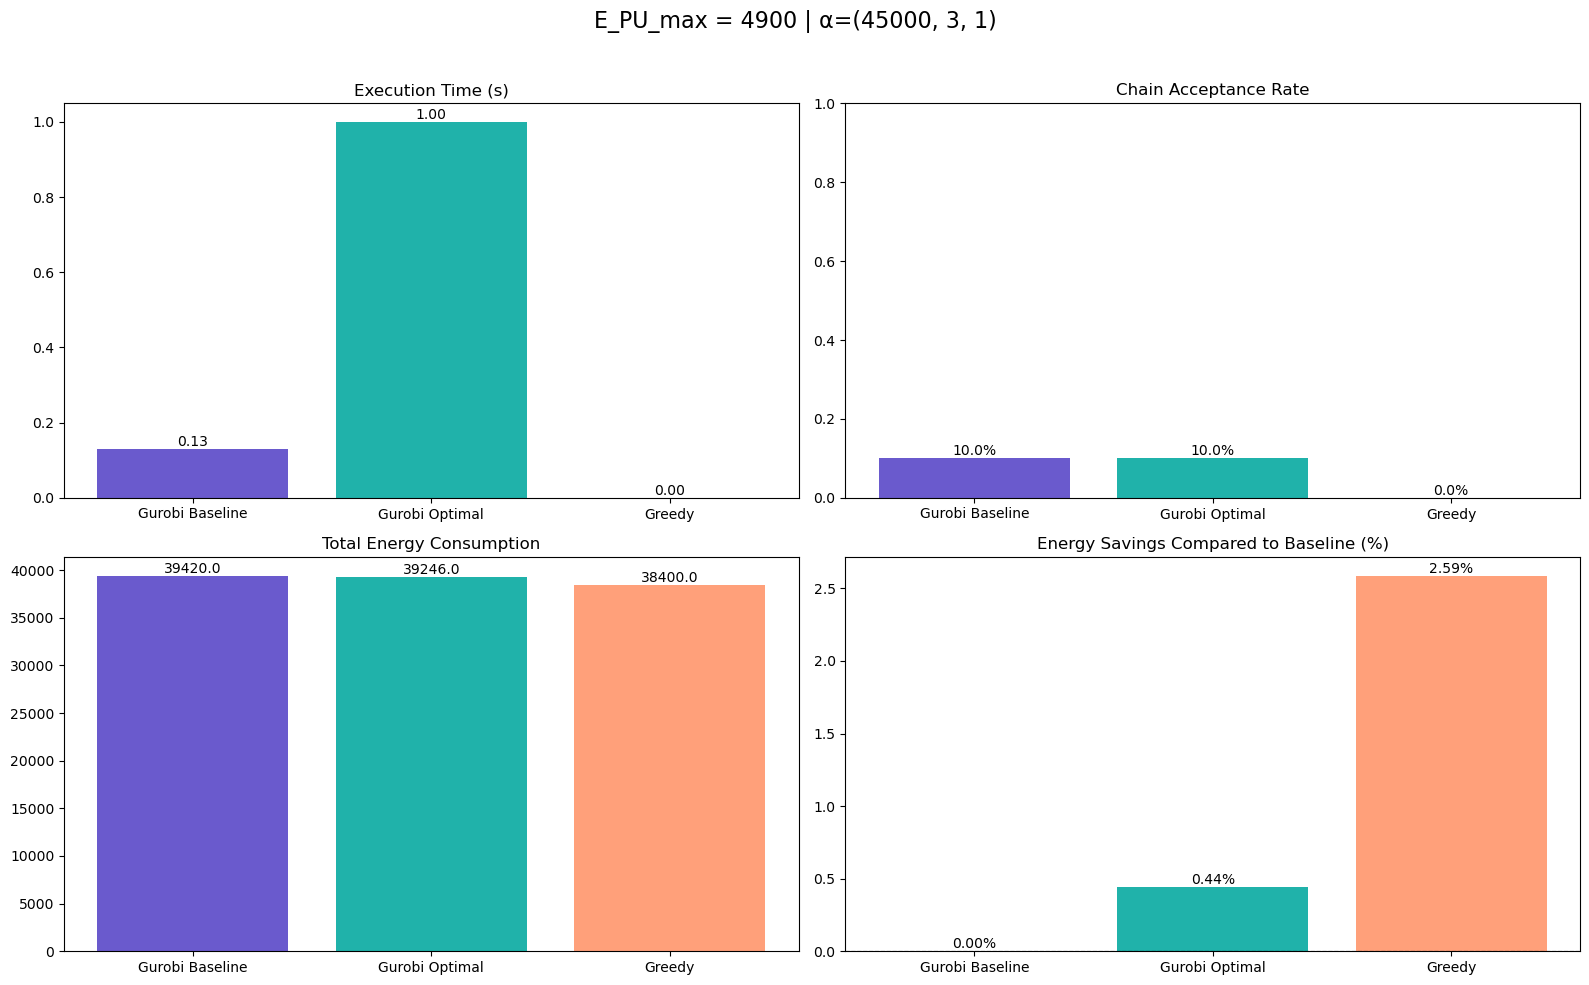

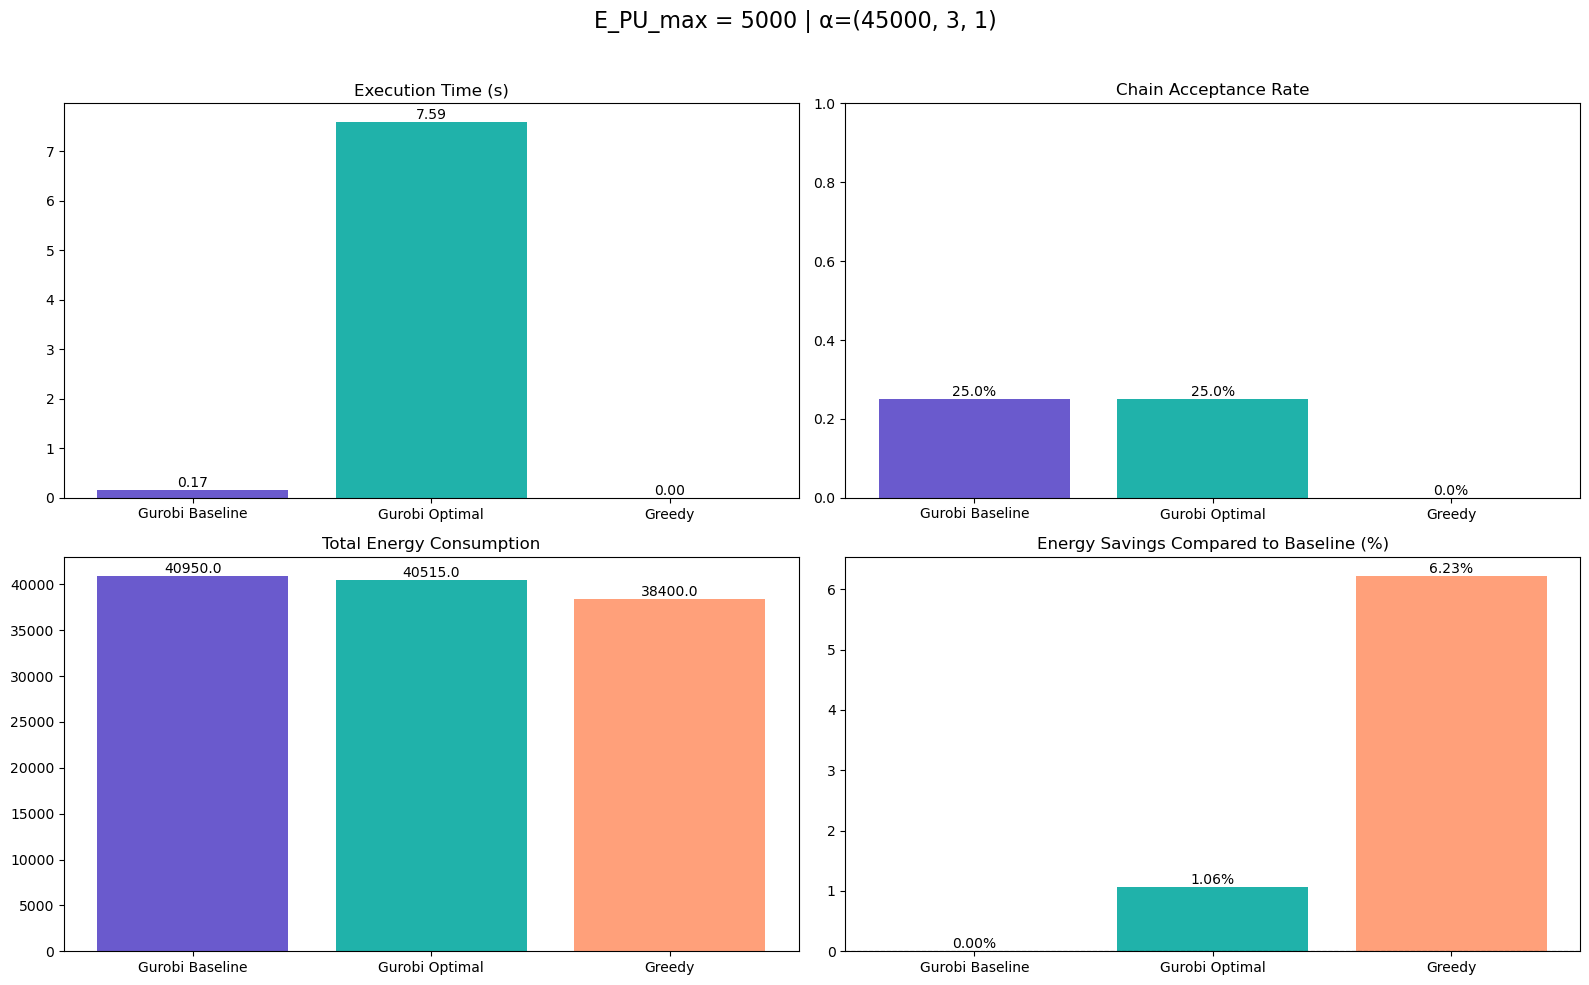

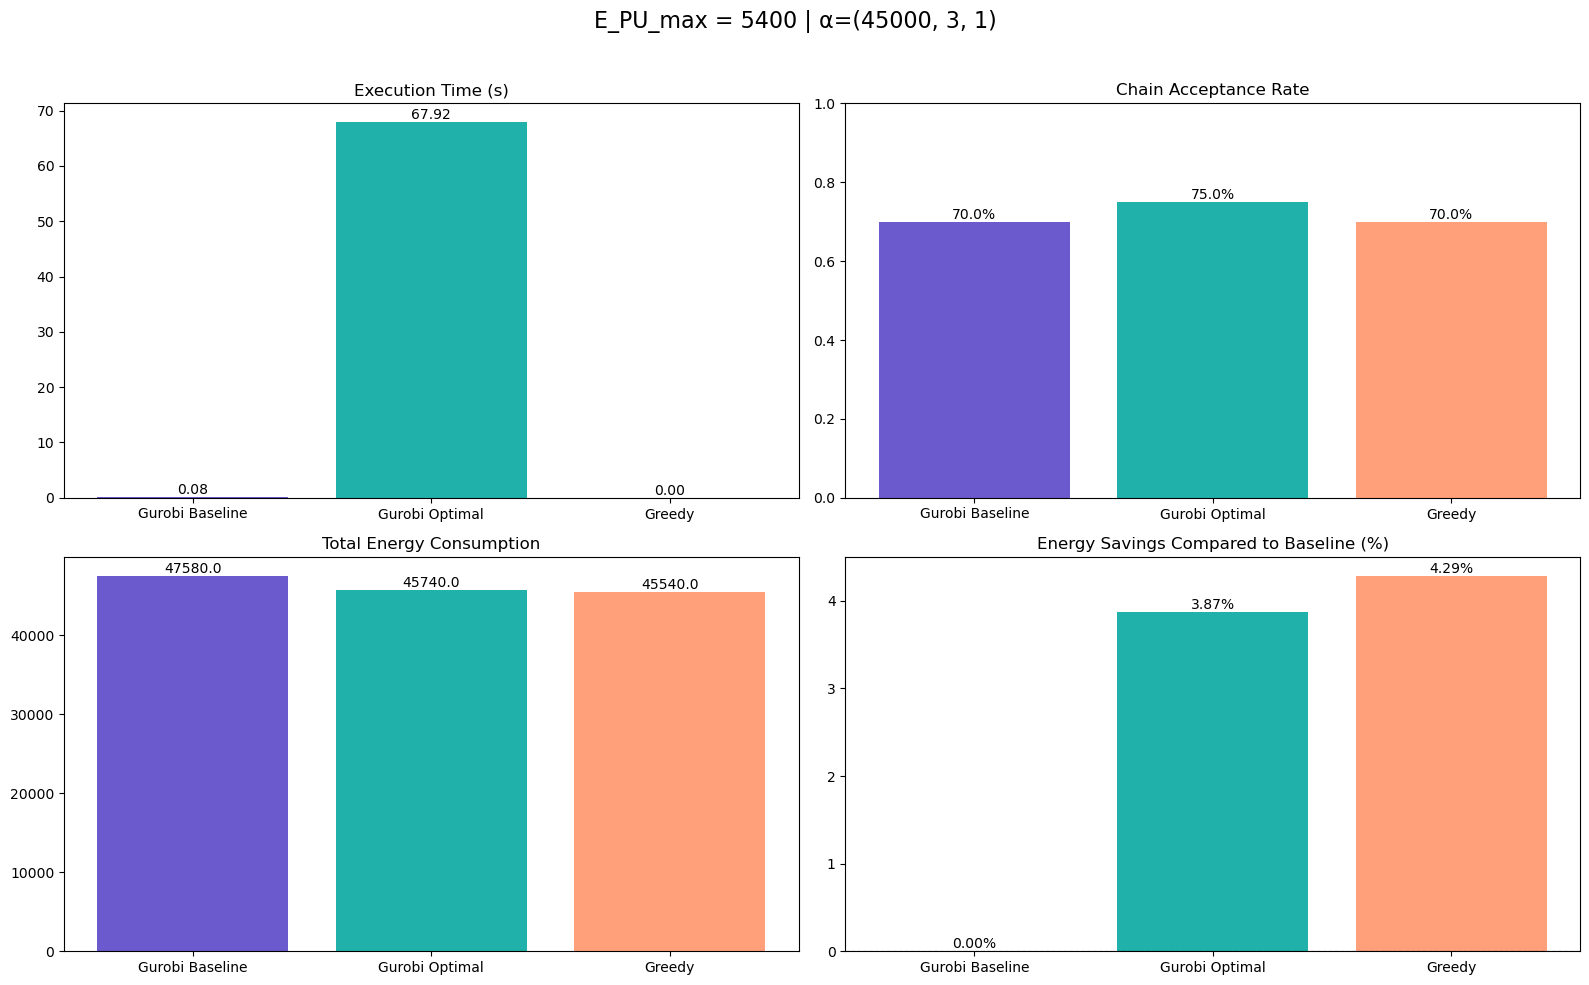

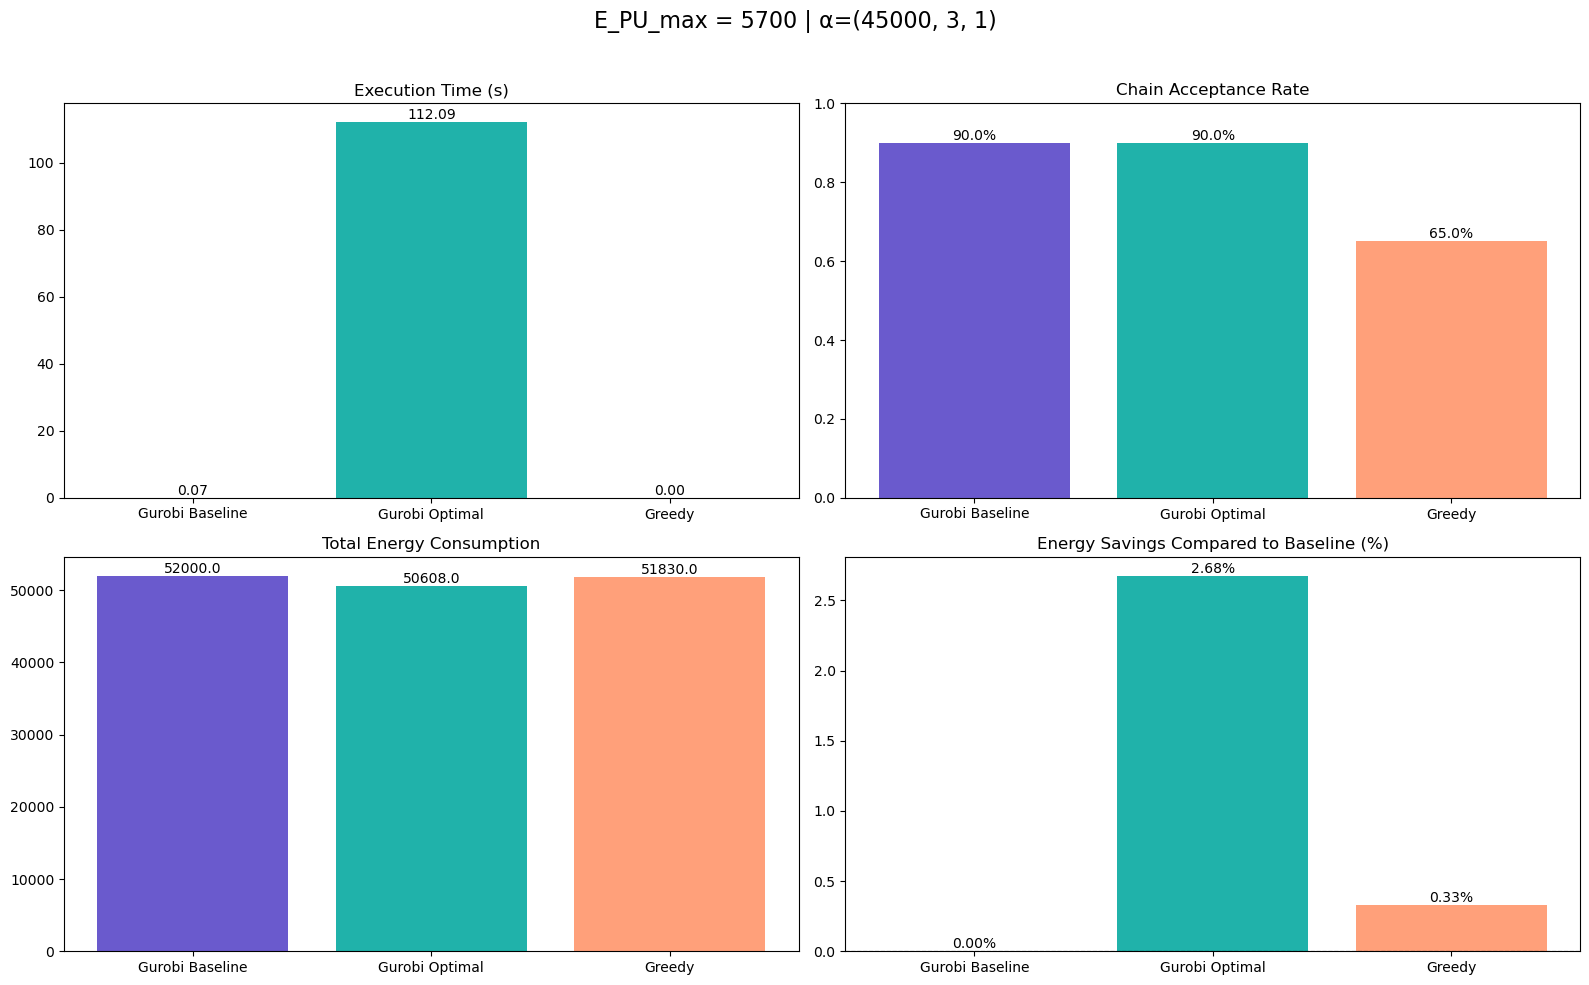

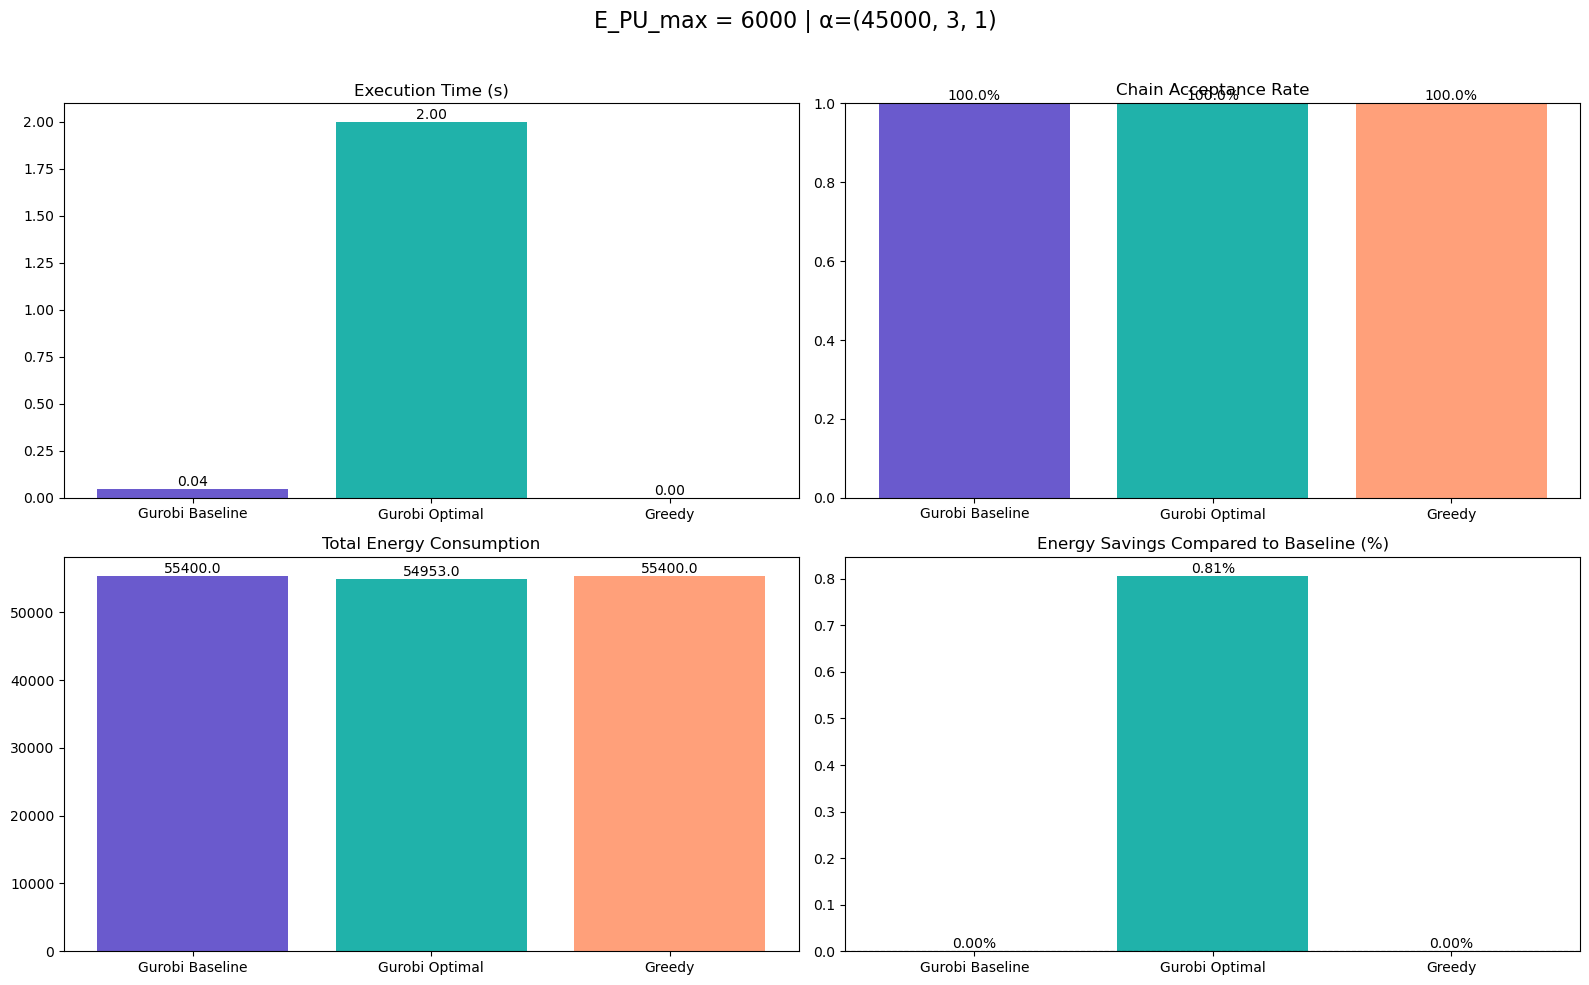

In [14]:
# alpha_1=40000.0, alpha_2=3, alpha_3=1.0

alpha_combination_5 = [
    (45000, 3, 1)  
]



all_results_5 = run_all_models(E_PU_max_list, alpha_combination_5)

plot_model(all_results_5)